#**Definizione di Nuove Strategie di Federated Learning con  Flower e Pytorch**

#**Installazione dei Pacchetti Richiesti**


*   Installazione di PyTorch (Torch)
*   Installazione di Torchvision per Computer Vision 
*   Installazione di Flower per l'Implementazione del Federated Learning 

In [111]:
!pip install -q flwr[simulation] torch torchvision

#**All General Imports**

In [112]:
import os
import timeit
import glob
import pandas as pd 
import platform
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

#**All Machine Learning Imports**

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torch import Tensor

#**All Federated Learning Imports**

In [114]:
import flwr as fl

#**All Globals**

In [115]:
n_clients = 4
strategy_colors = ['red', 'green', 'blue', 'cyan']
strategy_list = ['fedavg', 'fedadagrad', 'fedadam', 'fedyogi']
strategy_type = 'fedavg'
loop_on_strategies = True     # se True 
dataset = "har"                # cifar10, har

#**Hyper-parameters**

In [116]:
n_epochs = 50
n_rounds = 25
validation_split = 0.2
batch_size = 64
learning_rate = 0.0001
save_path = "epochs_"+str(n_epochs)+"_number_rounds_"+str(n_rounds)+"_learning_rate_"+str(learning_rate)

#**Initializations**

In [117]:
start_global_time = timeit.default_timer()

if not os.path.exists("./Outputs"):
    os.makedirs("./Outputs")

if not os.path.exists("./Outputs/"+save_path):
    os.makedirs("./Outputs/"+save_path)

DEVICE = torch.device("cpu")  # Prova "cuda" per addestramento su GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

OS = platform.system()           # Sistema Operativo

strategies_acc = []

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


#**All General Functions Definitions**

In [118]:
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d '+os.path.dirname(file_to_download))
    return True
  else: 
    return None

#**Data Download**


In [119]:
if dataset == "cifar10":
  transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  )
  trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
  testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

  print("Training Set size: ", len(trainset))
  print("Test Set size: ", len(testset))
elif dataset == "har": 
  out = data_download("./har_datasets_fl.zip", "1LUjU4yvBRh6FPBlIHRCD2uf5zMH6l9tC", OS) 
  #urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip", filename="har-data.zip")


#**Ripartizione del Training Set per il Federated Learning**

Il **Dataset** principale viene splittato **in N parti** tante quante il numero di client. Ciascun pezzo è costituito da differenti training e validation set, mentre il test set viene condiviso tra tutti i clients, di modo tale che esso sia sempre lo stesso e possa garantire confronti affidabili. Questo test set comune infatti permette di fare dei confronti tra differenti client con un unico e stabile test set. 

In [120]:
if dataset == "cifar10":
  partition_size = len(trainset) // n_clients
  lengths = [partition_size] * n_clients
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  print("Size of each Dataset Partition: ", partition_size)
  print("All Dataset Partitions sizes: ", lengths)

#**Preparazione dei Dati**

Per ciascun sottoinsieme, estraiamo un training set e un validation set e li wrappiamo all'interno di DataLoader, definendo il batch size, lo shuffle, ecc. Il testset viene condiviso tra tutti i client, mentre train e validation set sono specifici per ogni client: questo è vero sia per il dataset di benchmark cifar10 che per il dataset di human activity recognition (har). 

In [121]:
trainloaders = []
valloaders = []

if dataset == "cifar10": 
  for ds in datasets:
      len_val = len(ds) // validation_rate
      len_train = len(ds) - len_val
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size = batch_size, shuffle=True))
      valloaders.append(DataLoader(ds_val, batch_size = batch_size))

  testloader = DataLoader(testset, batch_size = batch_size)
elif dataset == "har":
  subdirectories = [f.path for f in os.scandir('./har_datasets_fl') if f.is_dir()]

  global_X_testset = pd.DataFrame()
  global_y_testset = pd.DataFrame()
 
  for subdirectory in subdirectories:
    fold_number = os.path.basename(subdirectory).split('-')[0].strip()    
    print("Reading : ", subdirectory)
    
    trainset = pd.read_csv(subdirectory+'/train/'+fold_number+'_ALL_train.csv', delimiter = ';')
    valset = trainset[-int(len(trainset)*validation_split):]
    trainset = trainset[0:-int(len(trainset)*validation_split)]
    testset = pd.read_csv(subdirectory+'/test/'+fold_number+'_ALL_test.csv', delimiter = ';')

    '''
    print(trainset.shape)
    print(valset.shape)
    print(testset.shape)
    '''

    X_train = pd.concat([trainset[str(i)] for i in range(561)], axis = 1)
    y_train = trainset['Y'] - 1

    X_val = pd.concat([valset[str(i)] for i in range(561)], axis = 1)
    y_val = valset['Y'] - 1

    X_test = pd.concat([testset[str(i)] for i in range(561)], axis = 1)
    y_test = testset['Y'] - 1

    global_X_testset = pd.concat([global_X_testset, X_test], axis=0)
    global_y_testset = pd.concat([global_y_testset, y_test], axis=0)

    training_data = torch.utils.data.TensorDataset(torch.tensor(X_train.values).float(), torch.as_tensor(y_train.values).squeeze())
    val_data = torch.utils.data.TensorDataset(torch.tensor(X_val.values).float(), torch.as_tensor(y_val.values).squeeze())
    trainloaders.append(DataLoader(training_data, batch_size=batch_size))
    valloaders.append(DataLoader(val_data, batch_size=batch_size))

test_data = torch.utils.data.TensorDataset(torch.tensor(global_X_testset.values).float(), torch.as_tensor(global_y_testset.values).squeeze())
test_dataloader = DataLoader(test_data, batch_size=batch_size)


Reading :  ./har_datasets_fl/3 - STATCAN
Reading :  ./har_datasets_fl/1 - ISTAT
Reading :  ./har_datasets_fl/2 - ONS
Reading :  ./har_datasets_fl/0 - CBS


In [122]:
print("Number of Training Subsets: ", len(trainloaders))

Number of Training Subsets:  4


In [123]:
print("Number of Validation Subsets: ", len(trainloaders))

Number of Validation Subsets:  4


#**Definizione del Modello**

In [124]:
class ConvNet(nn.Module):
    def __init__(self) -> None:
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MLP(nn.Module):
    """ Multi Layer Perceptron """
    def __init__(self) -> None:
        super(MLP, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(561, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def forward(self, x: Tensor) -> Tensor:
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Crea un'istanza del modello e ne ottiene i parametri
if dataset == "cifar10":
  Net = ConvNet
elif dataset == "har":
  Net = MLP

#**Addestramento del Modello**

Nel **federated learning**, il server manda i parametri globali del modello ai suoi client, e i client aggiornano il modello locale mediante i parametri ricevuti dal server. 

Dunque i client addestrano il modello sui dati locali (i quali influenza i parametri del modello localmente) e mandano i parametri del modello cambiati/aggiornati di nuovo indietro verso il server (o in alternativa, mandano i gradienti verso il server, non in questo caso i parametri completi del modello). 

Abbiamo bisogno pertanto di due funzioni di supporto per aggiornare il modello locale con i parametri ricevuti dal server (set_parameters) e ottenere i parametri aggiornati dal modello locale (get_parameters). Le seguenti funzioni eseguno queste operazioni per il modello Pytorch precedentemente definito. 

In sostanza usuamo **state_dict** per accedere ai tensori dei parametri del modello PyTorch. I tensori del parametro sono poi convertiti a/da una lista di array Numpy (che Flower è in grado di serializzare/deserializzare).

##**Aggiornamento dei Parametri del Modello**

In [125]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

##**Addestramento**

In [126]:
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metriche
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

#**Model Testing**

In [127]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total

    return accuracy, loss

#**Implementazione del Client Flower**

Come sappiamo i sistemi di Federated learning sono costituiti da una parte client e una parte serve. In Flower, creiamo i client implementando delle sottoclassi di `flwr.client.Client` o `flwr.client.NumPyClient`. 

Usiamo adesso `NumPyClient` dal momento che è più facile da implementare. 

Per implementare il client, creiamo una sottoclasse `flwr.client.NumPyClient` e implementiamo 3 metodi `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Ritorna i parametri del modello attuale. 
* `fit`: Riceve i parametri del modello dal server, addestra i parametri sui dati locali, e ritorna i parametri del modello aggiornati verso il server. 
* `evaluate`: Receve i parametri del modello dal server, valuta i parametri del modello sui dati locali, e ritorna il risultato della valutazione al server. 


In [128]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=n_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

Flower, di default, inizializza il modello gobale richiedendo un client casuale per l'inizializzazione dei parametri. In molti casi, vogliamo più controllo sull'inizializzazione dei parametri. Flower quindi permette quindi di passare i parametri inziali alla Strategia. 

Quando chiamiamo **start_simulation**, diciamo a Flower che ci sono 4 client. Flower aòòpra va avanti e richiede la strategia  FedAvg per selezionare i client. FedAvg sa che dovrebbe selezionalre il 100% dei client disponibili (fraction_fit=1.0), così va avanti e seleziona 4 client casualmente (cioè 100% dei 4).

#**Selezione della Strategia di Aggregazione Built-In**

INFO flwr 2023-06-08 15:23:19,674 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)



Analyzing Strategy... :  Fedavg
(launch_and_fit pid=50708) [Client 1] fit, config: {} [repeated 11x across cluster]
(launch_and_fit pid=50707) Epoch 1: train loss 0.0030662829522043467, accuracy 0.9428959891230455 [repeated 11x across cluster]
(launch_and_evaluate pid=50708) [Client 3] evaluate, config: {} [repeated 9x across cluster]


(pid=50708) 2023-06-08 15:06:17.308651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-08 15:23:25,172	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-08 15:23:26,930 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3923648102.0, 'CPU': 2.0, 'memory': 7847296206.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3923648102.0, 'CPU': 2.0, 'memory': 7847296206.0}
INFO flwr 2023-06-08 15:23:26,938 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-08 15:23:26,945 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-08 15:23:26,947 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2023-06-08

(launch_and_fit pid=55796) [Client 0] fit, config: {}
(launch_and_fit pid=55796) Epoch 1: train loss 0.02526571974158287, accuracy 0.3664174031271244
(launch_and_fit pid=55795) Epoch 15: train loss 0.004546018783003092, accuracy 0.9014276002719238
(launch_and_fit pid=55796) Epoch 16: train loss 0.0042570652440190315, accuracy 0.9061862678450034 [repeated 30x across cluster]
(launch_and_fit pid=55795) Epoch 27: train loss 0.002374900970607996, accuracy 0.9592114208021754 [repeated 23x across cluster]
(launch_and_fit pid=55796) Epoch 38: train loss 0.0015492341481149197, accuracy 0.9762066621346023 [repeated 21x across cluster]
(launch_and_fit pid=55795) [Client 3] fit, config: {}
(launch_and_fit pid=55796) Epoch 50: train loss 0.0010878092143684626, accuracy 0.981645139360979 [repeated 25x across cluster]
(launch_and_fit pid=55796) Epoch 11: train loss 0.006079749204218388, accuracy 0.8701563562202583
(launch_and_fit pid=55795) Epoch 11: train loss 0.006079749204218388, accuracy 0.87015

DEBUG flwr 2023-06-08 15:24:21,336 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-08 15:24:21,359 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-08 15:24:21,364 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:24:21,623 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-08 15:24:21,630 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-08 15:24:21,638 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {}
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55796) Epoch 3: train loss 0.0015056305564939976, accuracy 0.9714479945615228 [repeated 18x across cluster]
(launch_and_evaluate pid=55796) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 14: train loss 0.0009386578458361328, accuracy 0.9836845683208701
(launch_and_fit pid=55795) Epoch 17: train loss 0.0008487221784889698, accuracy 0.9850441876274643 [repeated 29x across cluster]
(launch_and_fit pid=55796) 
(launch_and_fit pid=55795) Epoch 28: train loss 0.000623991887550801, accuracy 0.990482664853841 [repeated 22x across cluster]
(launch_and_fit pid=55795) Epoch 39: train loss 0.0005096913664601743, accuracy 0.991162474507138 [repeated 22x across cluster]
(launch_and_fit pid=55796) [Client 1] fit, config: {}
(launch_and_fit pid=55795) Epoch 3: train loss 0.0014903686242178082, accuracy 0.970088375254928

DEBUG flwr 2023-06-08 15:25:03,236 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:25:03,266 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:25:03,652 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:25:03,656 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=55795) [Client 1] evaluate, config: {}
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_fit pid=55795) Epoch 50: train loss 0.0006239877548068762, accuracy 0.9884432358939497 [repeated 19x across cluster]
(launch_and_evaluate pid=55796) Epoch 10: train loss 0.0008361405343748629, accuracy 0.982324949014276
(launch_and_fit pid=55796) Epoch 11: train loss 0.0008670792449265718, accuracy 0.9802855200543847
(launch_and_fit pid=55796) Epoch 11: train loss 0.0008670792449265718, accuracy 0.9802855200543847 [repeated 22x across cluster]
(launch_and_fit pid=55795) Epoch 27: train loss 0.0007345738704316318, accuracy 0.9789259007477906 [repeated 30x across cluster]
(launch_and_fit pid=55795) Epoch 38: train loss 0.0006444499013014138, accuracy 0.981645139360979 [repeated 23x across cluster]
(launch_and_fit pid=55796) Epoch 49: train loss 0.0003645711694844067, accuracy 0.9932019034670292 [r

DEBUG flwr 2023-06-08 15:25:44,001 | server.py:232 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:25:44,024 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:25:44,250 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:25:44,253 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 2] evaluate, config: {}
(launch_and_fit pid=55795) [Client 3] fit, config: {}
(launch_and_fit pid=55796) Epoch 50: train loss 0.0004394912102725357, accuracy 0.991162474507138 [repeated 26x across cluster]
(launch_and_evaluate pid=55796) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 11: train loss 0.0004755121481139213, accuracy 0.9870836165873556
(launch_and_fit pid=55796) Epoch 11: train loss 0.0004755121481139213, accuracy 0.9870836165873556 [repeated 22x across cluster]
(launch_and_fit pid=55795) Epoch 22: train loss 0.0003971369587816298, accuracy 0.9898028552005439 [repeated 21x across cluster]
(launch_and_fit pid=55795) Epoch 36: train loss 0.00029910236480645835, accuracy 0.9945615227736234 [repeated 29x across cluster]
(launch_and_fit pid=55796) Epoch 48: train loss 0.0005583033198490739, accuracy 0.9796057104010877 [repeated 23x across cluster]
(launch_and_fit pid=55796) [Client 1] fit, co

DEBUG flwr 2023-06-08 15:26:27,697 | server.py:232 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:26:27,720 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:26:27,962 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:26:27,970 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 1] evaluate, config: {}
(launch_and_fit pid=55795) [Client 3] fit, config: {}
(launch_and_fit pid=55796) Epoch 5: train loss 0.0008235127897933125, accuracy 0.9748470428280082 [repeated 25x across cluster]
(launch_and_evaluate pid=55796) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 14: train loss 0.0005309227854013443, accuracy 0.9870836165873556
(launch_and_fit pid=55796) Epoch 17: train loss 0.00038142522680573165, accuracy 0.9898028552005439 [repeated 24x across cluster]
(launch_and_fit pid=55795) Epoch 27: train loss 0.000334837386617437, accuracy 0.990482664853841 [repeated 19x across cluster]
(launch_and_fit pid=55796) Epoch 40: train loss 0.00029013754101470113, accuracy 0.9938817131203264 [repeated 28x across cluster]
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 5: train loss 0.0005165468319319189, accuracy 0.9870836165873556 [repeated 26x across cl

DEBUG flwr 2023-06-08 15:27:11,527 | server.py:232 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures


(launch_and_fit pid=55796) Epoch 49: train loss 5.656423672917299e-05, accuracy 1.0 [repeated 19x across cluster]


DEBUG flwr 2023-06-08 15:27:11,550 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:27:11,795 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:27:11,799 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 2] evaluate, config: {}
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 12: train loss 0.00013089562708046287, accuracy 0.9972807613868117 [repeated 24x across cluster]
(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 14: train loss 0.00012083369074389338, accuracy 0.9972807613868117
(launch_and_fit pid=55796) Epoch 25: train loss 0.0003628167905844748, accuracy 0.9891230455472467 [repeated 26x across cluster]
(launch_and_fit pid=55796) Epoch 34: train loss 0.000355255528120324, accuracy 0.9918422841604351 [repeated 18x across cluster]
(launch_and_fit pid=55795) Epoch 48: train loss 0.00012591893028002232, accuracy 0.9966009517335146 [repeated 29x across cluster]
(launch_and_fit pid=55796) [Client 1] fit, config: {}
(launch_and_fit pid=55795) Epoch 10: train loss 0.00019928101391997188, accuracy 0.9972807613868117 [repeated 25x acro

DEBUG flwr 2023-06-08 15:27:54,603 | server.py:232 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:27:54,628 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:27:54,983 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:27:54,991 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 1] evaluate, config: {}
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_fit pid=55796) Epoch 4: train loss 0.00020723593479488045, accuracy 0.9952413324269205 [repeated 15x across cluster]
(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 12: train loss 0.0003456942504271865, accuracy 0.990482664853841
(launch_and_fit pid=55796) Epoch 18: train loss 9.525266068521887e-05, accuracy 0.9986403806934059 [repeated 27x across cluster]
(launch_and_fit pid=55796) Epoch 32: train loss 8.063215500442311e-05, accuracy 0.9986403806934059 [repeated 27x across cluster]
(launch_and_fit pid=55795) Epoch 39: train loss 2.111769026669208e-05, accuracy 1.0 [repeated 17x across cluster]
(launch_and_fit pid=55796) [Client 1] fit, config: {}
(launch_and_fit pid=55795) Epoch 2: train loss 0.0002470772305969149, accuracy 0.9925220938137321 [repeated 27x across cluster]
(launch_

DEBUG flwr 2023-06-08 15:28:37,422 | server.py:232 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:28:37,442 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:28:37,684 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:28:37,691 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 0] evaluate, config: {}
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_fit pid=55795) Epoch 1: train loss 0.0004132678441237658, accuracy 0.9898028552005439 [repeated 22x across cluster]
(launch_and_evaluate pid=55796) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 8: train loss 5.9616679209284484e-05, accuracy 0.9993201903467029
(launch_and_fit pid=55796) Epoch 9: train loss 5.9570218581939116e-05, accuracy 0.9986403806934059 [repeated 16x across cluster]
(launch_and_fit pid=55796) Epoch 23: train loss 6.668398327747127e-06, accuracy 1.0 [repeated 28x across cluster]
(launch_and_fit pid=55796) Epoch 37: train loss 4.332992375566391e-06, accuracy 1.0 [repeated 28x across cluster]
(launch_and_fit pid=55795) Epoch 44: train loss 1.0429107533127535e-05, accuracy 1.0 [repeated 15x across cluster]
(launch_and_fit pid=55796) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 8: 

DEBUG flwr 2023-06-08 15:29:21,694 | server.py:232 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:29:21,720 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:29:21,952 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:29:21,957 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 2] evaluate, config: {}
(launch_and_fit pid=55795) [Client 3] fit, config: {}
(launch_and_fit pid=55795) Epoch 7: train loss 1.3708275218959898e-05, accuracy 1.0 [repeated 25x across cluster]
(launch_and_evaluate pid=55796) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 11: train loss 0.0005784927634522319, accuracy 0.9830047586675731
(launch_and_fit pid=55796) Epoch 15: train loss 0.00026382171199657023, accuracy 0.9938817131203264 [repeated 16x across cluster]
(launch_and_fit pid=55796) Epoch 29: train loss 1.5001799511082936e-05, accuracy 1.0 [repeated 28x across cluster]
(launch_and_fit pid=55795) Epoch 43: train loss 2.7654557470668806e-06, accuracy 1.0 [repeated 28x across cluster]
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55796) Epoch 1: train loss 0.00032751954859122634, accuracy 0.991162474507138 [repeated 17x across cluster]
(launch_and_fit pid=55796) Epoch 1

DEBUG flwr 2023-06-08 15:30:05,514 | server.py:232 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:30:05,534 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:30:05,780 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:30:05,786 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {}
(launch_and_fit pid=55795) Epoch 50: train loss 2.0859069991274737e-06, accuracy 1.0 [repeated 26x across cluster]
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_evaluate pid=55795) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 13: train loss 3.353280135343084e-06, accuracy 1.0 [repeated 26x across cluster]
(launch_and_fit pid=55796) Epoch 14: train loss 3.1870981729298364e-06, accuracy 1.0
(launch_and_fit pid=55796) Epoch 22: train loss 2.3055445126374252e-06, accuracy 1.0 [repeated 18x across cluster]
(launch_and_fit pid=55796) Epoch 35: train loss 1.4986695759944269e-06, accuracy 1.0 [repeated 27x across cluster]
(launch_and_fit pid=55795) [Client 3] fit, config: {}
(launch_and_fit pid=55796) Epoch 49: train loss 1.018467287394742e-06, accuracy 1.0 [repeated 28x across cluster]
(launch_and_fit pid=55796) Epoch 9: train loss 9.361935371998698e-05, accurac

DEBUG flwr 2023-06-08 15:30:48,820 | server.py:232 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:30:48,841 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:30:49,068 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:30:49,077 | server.py:218 | fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 11: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 0] evaluate, config: {}
(launch_and_fit pid=55795) [Client 1] fit, config: {}
(launch_and_fit pid=55795) Epoch 8: train loss 0.0001408190291840583, accuracy 0.9959211420802175 [repeated 22x across cluster]
(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 14: train loss 7.19124946044758e-05, accuracy 0.9979605710401088
(launch_and_fit pid=55795) Epoch 22: train loss 6.4560504142718855e-06, accuracy 1.0 [repeated 28x across cluster]
(launch_and_fit pid=55795) Epoch 32: train loss 4.3928989725827705e-06, accuracy 1.0 [repeated 20x across cluster]
(launch_and_fit pid=55795) Epoch 45: train loss 2.868450110327103e-06, accuracy 1.0 [repeated 26x across cluster]
(launch_and_fit pid=55795) [Client 3] fit, config: {}
(launch_and_fit pid=55796) Epoch 8: train loss 8.601184526924044e-05, accuracy 0.9972807613868117 [repeated 28x across cluster]
(launch_and_fit pid=55796) Epoch 14: 

DEBUG flwr 2023-06-08 15:31:30,020 | server.py:232 | fit_round 11 received 4 results and 0 failures
DEBUG:flwr:fit_round 11 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:31:30,044 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:31:30,433 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:31:30,440 | server.py:218 | fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 12: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55796) [Client 1] evaluate, config: {}
(launch_and_fit pid=55796) [Client 1] fit, config: {}
(launch_and_fit pid=55796) Epoch 4: train loss 0.00019247781892772764, accuracy 0.9952413324269205 [repeated 17x across cluster]
(launch_and_evaluate pid=55796) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55795) Epoch 9: train loss 0.0001026498430292122, accuracy 0.9979605710401088
(launch_and_fit pid=55795) Epoch 16: train loss 4.021931545139523e-06, accuracy 1.0 [repeated 24x across cluster]
(launch_and_fit pid=55795) Epoch 31: train loss 2.246999883936951e-06, accuracy 1.0 [repeated 30x across cluster]
(launch_and_fit pid=55795) Epoch 41: train loss 1.753049446051591e-06, accuracy 1.0 [repeated 20x across cluster]
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 3: train loss 3.5086839488940313e-05, accuracy 1.0 [repeated 24x across cluster]
(launch_and_fit pid=55796) Epoch 14: train loss 1.63

DEBUG flwr 2023-06-08 15:32:12,863 | server.py:232 | fit_round 12 received 4 results and 0 failures
DEBUG:flwr:fit_round 12 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:32:12,883 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:32:13,126 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:32:13,133 | server.py:218 | fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 13: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 0] evaluate, config: {}
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 2: train loss 3.0004199288669042e-05, accuracy 1.0 [repeated 26x across cluster]
(launch_and_evaluate pid=55796) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 11: train loss 1.338158426733571e-06, accuracy 1.0
(launch_and_fit pid=55796) Epoch 12: train loss 2.3964439606061205e-05, accuracy 1.0 [repeated 21x across cluster]
(launch_and_fit pid=55795) Epoch 24: train loss 8.220071094910963e-07, accuracy 1.0 [repeated 23x across cluster]
(launch_and_fit pid=55795) Epoch 38: train loss 5.81791596232506e-07, accuracy 1.0 [repeated 28x across cluster]
(launch_and_fit pid=55795) Epoch 49: train loss 4.58077352050168e-07, accuracy 1.0 [repeated 22x across cluster]
(launch_and_fit pid=55795) [Client 3] fit, config: {}
(launch_and_fit pid=55796) Epoch 10: train loss 0.00011174897372256964, accuracy 0

DEBUG flwr 2023-06-08 15:32:55,540 | server.py:232 | fit_round 13 received 4 results and 0 failures
DEBUG:flwr:fit_round 13 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:32:55,565 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:32:55,797 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:32:55,805 | server.py:218 | fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 14: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {}
(launch_and_fit pid=55795) [Client 1] fit, config: {}
(launch_and_fit pid=55795) Epoch 11: train loss 1.288721523451386e-05, accuracy 1.0 [repeated 26x across cluster]
(launch_and_evaluate pid=55796) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 15: train loss 5.743105248257052e-06, accuracy 1.0
(launch_and_fit pid=55795) Epoch 23: train loss 3.3134224395325873e-06, accuracy 1.0 [repeated 24x across cluster]
(launch_and_fit pid=55796) Epoch 33: train loss 6.598576192118344e-07, accuracy 1.0 [repeated 21x across cluster]
(launch_and_fit pid=55796) Epoch 48: train loss 4.7198847141771694e-07, accuracy 1.0 [repeated 30x across cluster]
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_fit pid=55795) Epoch 11: train loss 7.5751609983854e-05, accuracy 0.9993201903467029 [repeated 26x across cluster]
(launch_and_fit pid=55796) Epoch 12: train loss 7.507798727601767e

DEBUG flwr 2023-06-08 15:33:36,512 | server.py:232 | fit_round 14 received 4 results and 0 failures
DEBUG:flwr:fit_round 14 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:33:36,538 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:33:36,890 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:33:36,896 | server.py:218 | fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 15: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {}
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 6: train loss 3.864030986733269e-06, accuracy 1.0 [repeated 16x across cluster]
(launch_and_evaluate pid=55796) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 12: train loss 7.635368888259109e-07, accuracy 1.0
(launch_and_fit pid=55795) Epoch 21: train loss 5.509691618499346e-07, accuracy 1.0 [repeated 30x across cluster]
(launch_and_fit pid=55795) Epoch 31: train loss 4.2948036593770667e-07, accuracy 1.0 [repeated 20x across cluster]
(launch_and_fit pid=55796) Epoch 38: train loss 9.864141929938341e-07, accuracy 1.0 [repeated 15x across cluster]
(launch_and_fit pid=55795) [Client 1] fit, config: {}
(launch_and_fit pid=55795) Epoch 2: train loss 0.00019526509277056903, accuracy 0.9938817131203264 [repeated 27x across cluster]
(launch_and_fit pid=55796) Epoch 15: train loss 4.7465964598814026

DEBUG flwr 2023-06-08 15:34:19,952 | server.py:232 | fit_round 15 received 4 results and 0 failures
DEBUG:flwr:fit_round 15 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:34:19,976 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:34:20,199 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:34:20,208 | server.py:218 | fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 16: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 0] evaluate, config: {}
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_fit pid=55795) Epoch 2: train loss 1.4279354218160734e-05, accuracy 1.0 [repeated 25x across cluster]
(launch_and_evaluate pid=55796) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 10: train loss 0.00035449740244075656, accuracy 0.9918422841604351
(launch_and_fit pid=55796) Epoch 12: train loss 4.310787517169956e-06, accuracy 1.0 [repeated 20x across cluster]
(launch_and_fit pid=55796) Epoch 25: train loss 1.787808855624462e-06, accuracy 1.0 [repeated 26x across cluster]
(launch_and_fit pid=55795) Epoch 39: train loss 9.60578859121597e-07, accuracy 1.0 [repeated 28x across cluster]
(launch_and_fit pid=55795) Epoch 49: train loss 7.786643436702434e-07, accuracy 1.0 [repeated 20x across cluster]
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 12: train loss 1.5304684666261892

DEBUG flwr 2023-06-08 15:35:02,761 | server.py:232 | fit_round 16 received 4 results and 0 failures
DEBUG:flwr:fit_round 16 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:35:02,782 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:35:03,023 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:35:03,026 | server.py:218 | fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 17: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=55795) Epoch 50: train loss 3.570816033970914e-07, accuracy 1.0 [repeated 26x across cluster]
(launch_and_evaluate pid=55795) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=55795) [Client 2] evaluate, config: {}
(launch_and_fit pid=55795) [Client 1] fit, config: {}
(launch_and_fit pid=55795) Epoch 14: train loss 1.96352880266204e-06, accuracy 1.0 [repeated 28x across cluster]
(launch_and_evaluate pid=55796) Epoch 14: train loss 1.96352880266204e-06, accuracy 1.0
(launch_and_fit pid=55796) Epoch 15: train loss 1.8137429833586793e-06, accuracy 1.0
(launch_and_fit pid=55796) Epoch 23: train loss 4.276494962596189e-07, accuracy 1.0 [repeated 19x across cluster]
(launch_and_fit pid=55795) Epoch 36: train loss 8.428428941442689e-07, accuracy 1.0 [repeated 26x across cluster]
(launch_and_fit pid=55796) [Client 0] fit, config: {}
(launch_and_fit pid=55796) Epoch 1: train loss 8.870061719790101e-05, accuracy 0.9972807613868117 [repeated 29x across cluster]
(launch_

DEBUG flwr 2023-06-08 15:35:45,018 | server.py:232 | fit_round 17 received 4 results and 0 failures
DEBUG:flwr:fit_round 17 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:35:45,045 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:35:45,279 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:35:45,283 | server.py:218 | fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 18: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 2] evaluate, config: {}
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_fit pid=55796) Epoch 9: train loss 5.577784349952708e-07, accuracy 1.0 [repeated 23x across cluster]
(launch_and_evaluate pid=55796) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 15: train loss 4.1968729647123837e-07, accuracy 1.0
(launch_and_fit pid=55796) Epoch 24: train loss 3.036137741219136e-07, accuracy 1.0 [repeated 30x across cluster]
(launch_and_fit pid=55795) Epoch 34: train loss 2.636344618167641e-07, accuracy 1.0 [repeated 20x across cluster]
(launch_and_fit pid=55796) Epoch 47: train loss 1.6232860389209236e-07, accuracy 1.0 [repeated 26x across cluster]
(launch_and_fit pid=55795) [Client 3] fit, config: {}
(launch_and_fit pid=55795) Epoch 12: train loss 9.178851314572967e-07, accuracy 1.0 [repeated 30x across cluster]
(launch_and_fit pid=55796) Epoch 15: train loss 1.861646296674735e-06, accuracy 

DEBUG flwr 2023-06-08 15:36:24,646 | server.py:232 | fit_round 18 received 4 results and 0 failures
DEBUG:flwr:fit_round 18 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:36:24,666 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:36:24,908 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:36:24,915 | server.py:218 | fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 19: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 2] evaluate, config: {}
(launch_and_fit pid=55795) [Client 1] fit, config: {}
(launch_and_fit pid=55795) Epoch 8: train loss 3.3535748116264585e-06, accuracy 1.0 [repeated 18x across cluster]
(launch_and_evaluate pid=55796) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 9: train loss 3.5770051454164786e-06, accuracy 1.0
(launch_and_fit pid=55795) Epoch 20: train loss 1.6187713072213228e-06, accuracy 1.0 [repeated 24x across cluster]
(launch_and_fit pid=55796) Epoch 34: train loss 5.121771664562402e-07, accuracy 1.0 [repeated 29x across cluster]
(launch_and_fit pid=55795) Epoch 45: train loss 6.945334121155611e-07, accuracy 1.0 [repeated 21x across cluster]
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_fit pid=55796) Epoch 6: train loss 8.023499731280026e-07, accuracy 1.0 [repeated 22x across cluster]
(launch_and_fit pid=55796) Epoch 14: train loss 4.220358391648915e-07, accuracy 1

DEBUG flwr 2023-06-08 15:37:08,514 | server.py:232 | fit_round 19 received 4 results and 0 failures
DEBUG:flwr:fit_round 19 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:37:08,539 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:37:08,792 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:37:08,799 | server.py:218 | fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 20: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 1] evaluate, config: {}
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 3: train loss 2.4537281205994077e-05, accuracy 0.9993201903467029 [repeated 25x across cluster]
(launch_and_evaluate pid=55795) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 12: train loss 5.456621693156194e-06, accuracy 1.0
(launch_and_fit pid=55795) Epoch 14: train loss 4.305831851070252e-07, accuracy 1.0 [repeated 22x across cluster]
(launch_and_fit pid=55796) Epoch 24: train loss 1.9448475541139487e-06, accuracy 1.0 [repeated 21x across cluster]
(launch_and_fit pid=55795) Epoch 39: train loss 1.9081609536897304e-07, accuracy 1.0 [repeated 29x across cluster]
(launch_and_fit pid=55795) Epoch 50: train loss 1.5341146308855969e-07, accuracy 1.0 [repeated 22x across cluster]
(launch_and_fit pid=55795) [Client 1] fit, config: {}
(launch_and_fit pid=55796) Epoch 10: train loss 3.8279598811641

DEBUG flwr 2023-06-08 15:37:53,091 | server.py:232 | fit_round 20 received 4 results and 0 failures
DEBUG:flwr:fit_round 20 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:37:53,120 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:37:53,382 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:37:53,387 | server.py:218 | fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 21: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {}
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 9: train loss 1.2453149338398362e-06, accuracy 1.0 [repeated 25x across cluster]
(launch_and_evaluate pid=55795) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 13: train loss 1.0061995681098779e-06, accuracy 1.0
(launch_and_fit pid=55795) Epoch 19: train loss 7.816367428858939e-07, accuracy 1.0 [repeated 21x across cluster]
(launch_and_fit pid=55795) Epoch 29: train loss 5.557259896704636e-07, accuracy 1.0 [repeated 20x across cluster]
(launch_and_fit pid=55796) Epoch 43: train loss 3.1706673553344444e-07, accuracy 1.0 [repeated 27x across cluster]
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_fit pid=55796) Epoch 4: train loss 6.407091404980747e-06, accuracy 1.0 [repeated 22x across cluster]
(launch_and_fit pid=55796) Epoch 8: train loss 1.048610329235089e-06, accuracy 1

DEBUG flwr 2023-06-08 15:38:39,610 | server.py:232 | fit_round 21 received 4 results and 0 failures
DEBUG:flwr:fit_round 21 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:38:39,637 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:38:39,903 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:38:39,914 | server.py:218 | fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 22: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 2] evaluate, config: {}
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 9: train loss 4.478625896808808e-07, accuracy 1.0 [repeated 23x across cluster]
(launch_and_evaluate pid=55796) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 13: train loss 3.1957893042999785e-07, accuracy 1.0
(launch_and_fit pid=55796) Epoch 20: train loss 7.337757210734708e-07, accuracy 1.0 [repeated 22x across cluster]
(launch_and_fit pid=55796) Epoch 26: train loss 6.023643095431908e-07, accuracy 1.0 [repeated 12x across cluster]
(launch_and_fit pid=55796) Epoch 35: train loss 4.7516812173853396e-07, accuracy 1.0 [repeated 18x across cluster]
(launch_and_fit pid=55795) Epoch 48: train loss 8.539746687574734e-08, accuracy 1.0 [repeated 27x across cluster]
(launch_and_fit pid=55796) [Client 3] fit, config: {}
(launch_and_fit pid=55795) Epoch 8: train loss 0.0003476988058537245, accuracy 0

DEBUG flwr 2023-06-08 15:39:28,225 | server.py:232 | fit_round 22 received 4 results and 0 failures
DEBUG:flwr:fit_round 22 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:39:28,258 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:39:28,511 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:39:28,517 | server.py:218 | fit_round 23: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 23: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 1] evaluate, config: {}
(launch_and_fit pid=55795) [Client 3] fit, config: {}
(launch_and_fit pid=55795) Epoch 1: train loss 3.252961323596537e-05, accuracy 0.9986403806934059 [repeated 13x across cluster]
(launch_and_evaluate pid=55796) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 14: train loss 6.263069280976197e-07, accuracy 1.0
(launch_and_fit pid=55795) Epoch 15: train loss 6.013231086399173e-07, accuracy 1.0 [repeated 28x across cluster]
(launch_and_fit pid=55795) Epoch 27: train loss 4.158775652740587e-07, accuracy 1.0 [repeated 25x across cluster]
(launch_and_fit pid=55795) Epoch 35: train loss 3.501235994463059e-07, accuracy 1.0 [repeated 16x across cluster]
(launch_and_fit pid=55795) Epoch 49: train loss 2.712238256208366e-07, accuracy 1.0 [repeated 27x across cluster]
(launch_and_fit pid=55796) [Client 0] fit, config: {}
(launch_and_fit pid=55796) Epoch 12: train loss 2.4253438368759817e

DEBUG flwr 2023-06-08 15:40:13,048 | server.py:232 | fit_round 23 received 4 results and 0 failures
DEBUG:flwr:fit_round 23 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:40:13,073 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:40:13,409 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:40:13,416 | server.py:218 | fit_round 24: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 24: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55796) [Client 2] evaluate, config: {}
(launch_and_fit pid=55795) [Client 0] fit, config: {}
(launch_and_fit pid=55796) Epoch 3: train loss 7.095624459907413e-05, accuracy 0.9986403806934059 [repeated 13x across cluster]
(launch_and_evaluate pid=55796) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 11: train loss 0.0002672506670933217, accuracy 0.9925220938137321
(launch_and_fit pid=55795) Epoch 16: train loss 1.2028724540869007e-06, accuracy 1.0 [repeated 27x across cluster]
(launch_and_fit pid=55796) Epoch 31: train loss 3.360210882874526e-07, accuracy 1.0 [repeated 29x across cluster]
(launch_and_fit pid=55795) Epoch 38: train loss 2.8606814339582343e-07, accuracy 1.0 [repeated 15x across cluster]
(launch_and_fit pid=55796) [Client 2] fit, config: {}
(launch_and_fit pid=55796) Epoch 2: train loss 1.4368657502927817e-05, accuracy 1.0 [repeated 26x across cluster]
(launch_and_fit pid=55795) Epoch 12: train loss 3.

DEBUG flwr 2023-06-08 15:40:57,086 | server.py:232 | fit_round 24 received 4 results and 0 failures
DEBUG:flwr:fit_round 24 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:40:57,113 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:40:57,484 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:40:57,494 | server.py:218 | fit_round 25: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 25: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=55795) [Client 3] evaluate, config: {}
(launch_and_fit pid=55795) [Client 2] fit, config: {}
(launch_and_fit pid=55795) Epoch 5: train loss 2.7229554689256474e-05, accuracy 0.9986403806934059 [repeated 13x across cluster]
(launch_and_evaluate pid=55795) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=55796) Epoch 7: train loss 2.290468046339811e-06, accuracy 1.0
(launch_and_fit pid=55796) Epoch 17: train loss 4.053118118463317e-06, accuracy 1.0 [repeated 23x across cluster]
(launch_and_fit pid=55796) Epoch 30: train loss 1.125248445532634e-06, accuracy 1.0 [repeated 26x across cluster]
(launch_and_fit pid=55796) Epoch 39: train loss 7.191072768364393e-07, accuracy 1.0 [repeated 17x across cluster]
(launch_and_fit pid=55796) [Client 3] fit, config: {}
(launch_and_fit pid=55795) Epoch 50: train loss 1.3461730929975602e-07, accuracy 1.0 [repeated 24x across cluster]
(launch_and_fit pid=55795) Epoch 13: train loss 6.866799822091707e

DEBUG flwr 2023-06-08 15:41:42,676 | server.py:232 | fit_round 25 received 4 results and 0 failures
DEBUG:flwr:fit_round 25 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:41:42,697 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:41:42,921 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
INFO flwr 2023-06-08 15:41:42,929 | server.py:147 | FL finished in 1095.9725066849996
INFO:flwr:FL finished in 1095.9725066849996
INFO flwr 2023-06-08 15:41:42,935 | app.py:218 | app_fit: losses_distributed [(1, 0.9309718437783832), (2, 0.9436875567665758), (3, 0.9518619436875567), (4, 0.9527702089009991), (5, 0.950045413260672), (6, 0.9518619436875567), (7, 0.9564032697547683), (8, 0.958219800181653), (9, 0.9509536784741144), (10, 0.9527702089009991), (11, 0.9564032697547683), (12, 0.959128

(launch_and_fit pid=55796) Epoch 50: train loss 2.2304438118680991e-07, accuracy 1.0 [repeated 28x across cluster]
(launch_and_evaluate pid=55795) [Client 0] evaluate, config: {}


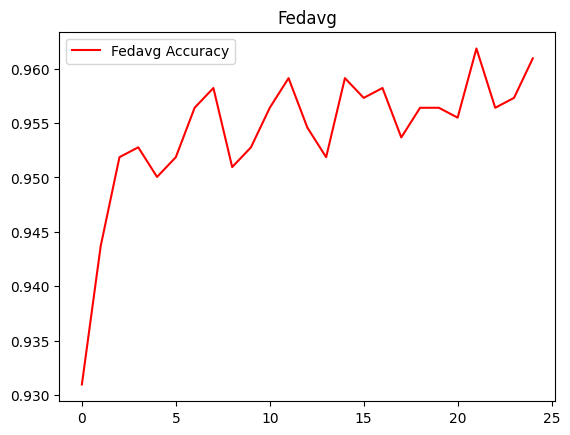

INFO flwr 2023-06-08 15:41:43,525 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)



Analyzing Strategy... :  Fedadagrad
(launch_and_evaluate pid=55796) [Client 1] evaluate, config: {} [repeated 2x across cluster]


(pid=55796) 2023-06-08 15:23:29.788162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-08 15:41:48,995	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-08 15:41:50,827 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7847220020.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3923610009.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7847220020.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3923610009.0}
INFO flwr 2023-06-08 15:41:50,840 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-08 15:41:50,848 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-08 15:41:50,850 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2023-06-08

(launch_and_fit pid=66075) [Client 2] fit, config: {}
(launch_and_fit pid=66075) Epoch 1: train loss 0.02485586889088154, accuracy 0.451393609789259
(launch_and_fit pid=66074) Epoch 8: train loss 0.007703953422605991, accuracy 0.840244731475187
(launch_and_fit pid=66075) Epoch 10: train loss 0.00671473378315568, accuracy 0.8592794017675051 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 24: train loss 0.0027630471158772707, accuracy 0.9490142760027193 [repeated 29x across cluster]
(launch_and_fit pid=66074) Epoch 35: train loss 0.0018148858798667789, accuracy 0.9639700883752549 [repeated 23x across cluster]
(launch_and_fit pid=66074) Epoch 43: train loss 0.0014145411550998688, accuracy 0.972807613868117 [repeated 15x across cluster]
(launch_and_fit pid=66075) [Client 0] fit, config: {}
(launch_and_fit pid=66074) Epoch 6: train loss 0.00897154863923788, accuracy 0.8334466349422162 [repeated 27x across cluster]
(launch_and_fit pid=66074) Epoch 14: train loss 0.004825903102

DEBUG flwr 2023-06-08 15:42:44,384 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-08 15:42:44,410 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-08 15:42:44,423 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:42:44,704 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-08 15:42:44,714 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-08 15:42:44,716 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=66074) [Client 3] evaluate, config: {}
(launch_and_fit pid=66074) [Client 3] fit, config: {}
(launch_and_fit pid=66074) Epoch 2: train loss 2.8411920070648193, accuracy 0.6872875594833446 [repeated 22x across cluster]
(launch_and_evaluate pid=66075) Epoch 6: train loss 0.09781674295663834, accuracy 0.9347382732834806
(launch_and_fit pid=66075) Epoch 6: train loss 0.09205490350723267, accuracy 0.9422161794697484
(launch_and_fit pid=66075) Epoch 8: train loss 0.07927879691123962, accuracy 0.947654656696125 [repeated 13x across cluster]
(launch_and_fit pid=66075) Epoch 19: train loss 0.058373089879751205, accuracy 0.9537729435757988 [repeated 22x across cluster]
(launch_and_fit pid=66075) Epoch 29: train loss 0.04983871057629585, accuracy 0.9537729435757988 [repeated 20x across cluster]
(launch_and_fit pid=66074) Epoch 37: train loss 0.03831348195672035, accuracy 0.9632902787219578 [repeated 14x acros

DEBUG flwr 2023-06-08 15:43:43,307 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:43:43,340 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:43:43,614 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:43:43,618 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 2] evaluate, config: {}
(launch_and_fit pid=66074) [Client 1] fit, config: {}
(launch_and_fit pid=66075) Epoch 50: train loss 0.031007926911115646, accuracy 0.9653297076818491 [repeated 16x across cluster]
(launch_and_evaluate pid=66075) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 10: train loss 118.67050170898438, accuracy 0.4357579877634262
(launch_and_fit pid=66074) Epoch 10: train loss 118.67050170898438, accuracy 0.4357579877634262 [repeated 20x across cluster]
(launch_and_fit pid=66075) Epoch 17: train loss 64.72259521484375, accuracy 0.4636301835486064 [repeated 13x across cluster]
(launch_and_fit pid=66074) Epoch 28: train loss 16.58389663696289, accuracy 0.681169272603671 [repeated 22x across cluster]
(launch_and_fit pid=66074) Epoch 37: train loss 7.166759014129639, accuracy 0.7185588035350102 [repeated 19x across cluster]
(launch_and_fit pid=66074) Epoch 42: train loss 2.454478025436401

DEBUG flwr 2023-06-08 15:44:44,247 | server.py:232 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:44:44,279 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:44:44,569 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:44:44,573 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=66074) [Client 2] evaluate, config: {}
(launch_and_fit pid=66074) [Client 0] fit, config: {}
(launch_and_fit pid=66074) Epoch 7: train loss 31.122081756591797, accuracy 0.3222297756628144 [repeated 19x across cluster]
(launch_and_evaluate pid=66075) Epoch 12: train loss 19.5134334564209, accuracy 0.36777702243371857
(launch_and_fit pid=66075) Epoch 13: train loss 17.889284133911133, accuracy 0.38273283480625425
(launch_and_fit pid=66074) Epoch 20: train loss 9.289653778076172, accuracy 0.4065261726716519 [repeated 26x across cluster]
(launch_and_fit pid=66075) Epoch 26: train loss 3.8629112243652344, accuracy 0.4357579877634262 [repeated 13x across cluster]
(launch_and_fit pid=66074) Epoch 37: train loss 1.496492624282837, accuracy 0.6879673691366417 [repeated 21x across cluster]
(launch_and_fit pid=66074) Epoch 48: train loss 0.08920539915561676, accuracy 0.8116927260367097 [repeated 21x across cl

DEBUG flwr 2023-06-08 15:45:37,187 | server.py:232 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:45:37,215 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:45:37,463 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:45:37,471 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 2] evaluate, config: {}
(launch_and_fit pid=66074) [Client 2] fit, config: {}
(launch_and_fit pid=66074) Epoch 4: train loss 4.6020636558532715, accuracy 0.44255608429639703 [repeated 18x across cluster]
(launch_and_evaluate pid=66075) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 8: train loss 1.188942551612854, accuracy 0.4813052345343304
(launch_and_fit pid=66075) Epoch 10: train loss 0.5129315257072449, accuracy 0.7124405166553365 [repeated 12x across cluster]
(launch_and_fit pid=66074) Epoch 18: train loss 0.054155588150024414, accuracy 0.8456832087015635 [repeated 17x across cluster]
(launch_and_fit pid=66074) Epoch 27: train loss 0.029423058032989502, accuracy 0.8783140720598233 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 32: train loss 0.024152671918272972, accuracy 0.8891910265125765 [repeated 10x across cluster]
(launch_and_fit pid=66075) Epoch 41: train loss 0.017255503

DEBUG flwr 2023-06-08 15:46:49,161 | server.py:232 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:46:49,190 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:46:49,461 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:46:49,468 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 2] evaluate, config: {}
(launch_and_fit pid=66074) [Client 3] fit, config: {}
(launch_and_fit pid=66075) Epoch 9: train loss 0.037446070462465286, accuracy 0.8817131203263087 [repeated 19x across cluster]
(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 11: train loss 0.02330278977751732, accuracy 0.8993881713120326
(launch_and_fit pid=66075) Epoch 17: train loss 0.014577450230717659, accuracy 0.9163834126444595 [repeated 16x across cluster]
(launch_and_fit pid=66075) Epoch 24: train loss 0.010895809158682823, accuracy 0.9299796057104011 [repeated 14x across cluster]
(launch_and_fit pid=66075) Epoch 33: train loss 0.008306797593832016, accuracy 0.9394969408565602 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 39: train loss 0.00738933589309454, accuracy 0.9517335146159075 [repeated 12x across cluster]
(launch_and_fit pid=66074) Epoch 46: train loss 0.0064

DEBUG flwr 2023-06-08 15:47:58,295 | server.py:232 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:47:58,321 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:47:58,580 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:47:58,584 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=66075) Epoch 50: train loss 0.006189210340380669, accuracy 0.9483344663494222 [repeated 16x across cluster]
(launch_and_evaluate pid=66074) [Client 3] evaluate, config: {}
(launch_and_fit pid=66075) [Client 0] fit, config: {}
(launch_and_fit pid=66074) Epoch 5: train loss 0.971676766872406, accuracy 0.6295037389530931 [repeated 10x across cluster]
(launch_and_evaluate pid=66075) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66074) Epoch 6: train loss 0.3360671401023865, accuracy 0.7117607070020394
(launch_and_fit pid=66075) Epoch 14: train loss 0.006934737786650658, accuracy 0.9415363698164514 [repeated 17x across cluster]
(launch_and_fit pid=66075) Epoch 23: train loss 0.005294730421155691, accuracy 0.9496940856560163 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 28: train loss 0.00513831852003932, accuracy 0.9551325628823929 [repeated 11x across cluster]
(launch_and_fit pid=66074) Epoch 37: train loss 0.004268130

DEBUG flwr 2023-06-08 15:49:09,802 | server.py:232 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:49:09,830 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:49:10,053 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:49:10,061 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {}
(launch_and_fit pid=66074) [Client 2] fit, config: {}
(launch_and_fit pid=66074) Epoch 5: train loss 0.04383727163076401, accuracy 0.8647178789938818 [repeated 17x across cluster]
(launch_and_evaluate pid=66075) Epoch 10: train loss 0.007396058179438114, accuracy 0.947654656696125
(launch_and_fit pid=66075) Epoch 10: train loss 0.007283891551196575, accuracy 0.947654656696125
(launch_and_fit pid=66075) Epoch 13: train loss 0.00547473318874836, accuracy 0.9517335146159075 [repeated 16x across cluster]
(launch_and_fit pid=66075) Epoch 19: train loss 0.004407838452607393, accuracy 0.9544527532290958 [repeated 12x across cluster]
(launch_and_fit pid=66074) Epoch 24: train loss 0.004267077427357435, accuracy 0.9571719918422842 [repeated 11x across cluster]
(launch_and_fit pid=66075) Epoch 32: train loss 0.003190735587850213, accuracy 0.9619306594153637 [repeated 15

DEBUG flwr 2023-06-08 15:50:16,782 | server.py:232 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:50:16,812 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:50:17,034 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:50:17,038 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {}
(launch_and_fit pid=66074) [Client 3] fit, config: {}
(launch_and_fit pid=66075) Epoch 4: train loss 0.015503942035138607, accuracy 0.9313392250169953 [repeated 11x across cluster]
(launch_and_evaluate pid=66075) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 6: train loss 0.0037317010574042797, accuracy 0.9707681849082257
(launch_and_fit pid=66074) Epoch 13: train loss 0.0020902659744024277, accuracy 0.9748470428280082 [repeated 17x across cluster]
(launch_and_fit pid=66074) Epoch 23: train loss 0.0016582370735704899, accuracy 0.9789259007477906 [repeated 20x across cluster]
(launch_and_fit pid=66075) Epoch 29: train loss 0.0020309370011091232, accuracy 0.9687287559483345 [repeated 12x across cluster]
(launch_and_fit pid=66075) Epoch 38: train loss 0.0017762081697583199, accuracy 0.9707681849082257 [repeated 18x across cluster]
(launch_and_fit pid=66075) Epoch 48: train loss 

DEBUG flwr 2023-06-08 15:51:22,288 | server.py:232 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:51:22,320 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:51:22,643 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:51:22,647 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 2] evaluate, config: {}
(launch_and_fit pid=66074) [Client 2] fit, config: {}
(launch_and_fit pid=66074) Epoch 4: train loss 0.006755786016583443, accuracy 0.9612508497620667 [repeated 12x across cluster]
(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 10: train loss 0.001854122499935329, accuracy 0.9802855200543847
(launch_and_fit pid=66075) Epoch 14: train loss 0.0014893426559865475, accuracy 0.981645139360979 [repeated 20x across cluster]
(launch_and_fit pid=66074) Epoch 22: train loss 0.0017038504593074322, accuracy 0.9721278042148198 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 29: train loss 0.0015176251763477921, accuracy 0.972807613868117 [repeated 14x across cluster]
(launch_and_fit pid=66075) Epoch 41: train loss 0.0011529921321198344, accuracy 0.9809653297076818 [repeated 20x across cluster]
(launch_and_fit pid=66075) Epoch 48: train loss 0.

DEBUG flwr 2023-06-08 15:52:26,181 | server.py:232 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:52:26,211 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:52:26,438 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:52:26,444 | server.py:218 | fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 11: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {}
(launch_and_fit pid=66074) [Client 0] fit, config: {}
(launch_and_fit pid=66075) Epoch 5: train loss 0.001417724066413939, accuracy 0.9755268524813052 [repeated 17x across cluster]
(launch_and_evaluate pid=66075) Epoch 10: train loss 0.0011564192827790976, accuracy 0.9768864717878993
(launch_and_fit pid=66075) Epoch 10: train loss 0.0011564192827790976, accuracy 0.9768864717878993
(launch_and_fit pid=66074) Epoch 15: train loss 0.0010691072093322873, accuracy 0.9775662814411965 [repeated 20x across cluster]
(launch_and_fit pid=66075) Epoch 20: train loss 0.0010803967015817761, accuracy 0.9789259007477906 [repeated 11x across cluster]
(launch_and_fit pid=66074) Epoch 30: train loss 0.0008322359644807875, accuracy 0.9802855200543847 [repeated 19x across cluster]
(launch_and_fit pid=66074) Epoch 40: train loss 0.0007410632679238915, accuracy 0.9843643779741672 [r

DEBUG flwr 2023-06-08 15:53:29,970 | server.py:232 | fit_round 11 received 4 results and 0 failures
DEBUG:flwr:fit_round 11 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:53:30,001 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:53:30,233 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:53:30,241 | server.py:218 | fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 12: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {}
(launch_and_fit pid=66074) [Client 2] fit, config: {}
(launch_and_fit pid=66074) Epoch 3: train loss 0.0020297567825764418, accuracy 0.9789259007477906 [repeated 16x across cluster]
(launch_and_evaluate pid=66074) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 10: train loss 0.0011619905708357692, accuracy 0.981645139360979
(launch_and_fit pid=66074) Epoch 12: train loss 0.001092681661248207, accuracy 0.982324949014276 [repeated 18x across cluster]
(launch_and_fit pid=66075) Epoch 18: train loss 0.0007461493951268494, accuracy 0.982324949014276 [repeated 12x across cluster]
(launch_and_fit pid=66075) Epoch 28: train loss 0.0006365685258060694, accuracy 0.9843643779741672 [repeated 20x across cluster]
(launch_and_fit pid=66075) Epoch 37: train loss 0.0005796843906864524, accuracy 0.9870836165873556 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 43: train loss 0.

DEBUG flwr 2023-06-08 15:54:33,796 | server.py:232 | fit_round 12 received 4 results and 0 failures
DEBUG:flwr:fit_round 12 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:54:33,824 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:54:34,060 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:54:34,070 | server.py:218 | fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 13: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {}
(launch_and_fit pid=66074) [Client 0] fit, config: {}
(launch_and_fit pid=66074) Epoch 1: train loss 0.049305323511362076, accuracy 0.8484024473147519 [repeated 16x across cluster]
(launch_and_evaluate pid=66075) Epoch 7: train loss 0.001013685017824173, accuracy 0.9768864717878993
(launch_and_fit pid=66075) Epoch 7: train loss 0.001013685017824173, accuracy 0.9768864717878993
(launch_and_fit pid=66074) Epoch 8: train loss 0.0007314741960726678, accuracy 0.981645139360979 [repeated 14x across cluster]
(launch_and_fit pid=66075) Epoch 15: train loss 0.0007369574741460383, accuracy 0.982324949014276 [repeated 16x across cluster]
(launch_and_fit pid=66074) Epoch 26: train loss 0.0005382433300837874, accuracy 0.9864038069340585 [repeated 18x across cluster]
(launch_and_fit pid=66075) Epoch 28: train loss 0.0005168409552425146, accuracy 0.9884432358939497 [repeated

DEBUG flwr 2023-06-08 15:55:40,942 | server.py:232 | fit_round 13 received 4 results and 0 failures
DEBUG:flwr:fit_round 13 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:55:40,982 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:55:41,312 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:55:41,317 | server.py:218 | fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 14: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66075) [Client 1] evaluate, config: {}
(launch_and_fit pid=66074) [Client 1] fit, config: {}
(launch_and_fit pid=66074) Epoch 1: train loss 0.028496436774730682, accuracy 0.9082256968048946 [repeated 11x across cluster]
(launch_and_evaluate pid=66075) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 7: train loss 0.0007989196456037462, accuracy 0.9843643779741672
(launch_and_fit pid=66074) Epoch 9: train loss 0.0006625743699260056, accuracy 0.9870836165873556 [repeated 16x across cluster]
(launch_and_fit pid=66075) Epoch 19: train loss 0.00047844284563325346, accuracy 0.9870836165873556 [repeated 21x across cluster]
(launch_and_fit pid=66075) Epoch 26: train loss 0.0004440025659278035, accuracy 0.9898028552005439 [repeated 14x across cluster]
(launch_and_fit pid=66075) Epoch 34: train loss 0.0007372054969891906, accuracy 0.9843643779741672 [repeated 16x across cluster]
(launch_and_fit pid=66074) Epoch 45: train loss 

DEBUG flwr 2023-06-08 15:56:44,923 | server.py:232 | fit_round 14 received 4 results and 0 failures
DEBUG:flwr:fit_round 14 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:56:44,963 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=66074) Epoch 50: train loss 0.0005809819558635354, accuracy 0.9864038069340585 [repeated 12x across cluster]


DEBUG flwr 2023-06-08 15:56:45,329 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:56:45,337 | server.py:218 | fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 15: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {}
(launch_and_fit pid=66074) [Client 2] fit, config: {}
(launch_and_fit pid=66074) Epoch 8: train loss 0.0003601029748097062, accuracy 0.9891230455472467 [repeated 16x across cluster]
(launch_and_evaluate pid=66074) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 10: train loss 0.0004567427677102387, accuracy 0.9877634262406526
(launch_and_fit pid=66075) Epoch 19: train loss 0.0003930920211132616, accuracy 0.9918422841604351 [repeated 20x across cluster]
(launch_and_fit pid=66075) Epoch 25: train loss 0.0003321107942610979, accuracy 0.9918422841604351 [repeated 11x across cluster]
(launch_and_fit pid=66074) Epoch 32: train loss 0.0003869548672810197, accuracy 0.9884432358939497 [repeated 19x across cluster]
(launch_and_fit pid=66075) Epoch 45: train loss 0.00024514846154488623, accuracy 0.9952413324269205 [repeated 20x across cluster]
(launch_and_fit pid=66075) [Client 1] fit, co

DEBUG flwr 2023-06-08 15:57:48,424 | server.py:232 | fit_round 15 received 4 results and 0 failures
DEBUG:flwr:fit_round 15 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:57:48,454 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:57:48,688 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:57:48,692 | server.py:218 | fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 16: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 2] evaluate, config: {}
(launch_and_fit pid=66074) [Client 0] fit, config: {}
(launch_and_fit pid=66075) Epoch 9: train loss 0.00045501638669520617, accuracy 0.9918422841604351 [repeated 18x across cluster]
(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 10: train loss 0.00042211648542433977, accuracy 0.9884432358939497
(launch_and_fit pid=66074) Epoch 18: train loss 0.00048027292359620333, accuracy 0.9870836165873556 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 26: train loss 0.0004347182693891227, accuracy 0.9884432358939497 [repeated 16x across cluster]
(launch_and_fit pid=66075) Epoch 36: train loss 0.00027264381060376763, accuracy 0.9966009517335146 [repeated 21x across cluster]
(launch_and_fit pid=66075) Epoch 44: train loss 0.0002217062865383923, accuracy 0.9972807613868117 [repeated 16x across cluster]
(launch_and_fit pid=66074) [Client 2] fit,

DEBUG flwr 2023-06-08 15:58:50,658 | server.py:232 | fit_round 16 received 4 results and 0 failures
DEBUG:flwr:fit_round 16 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:58:50,692 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:58:50,945 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:58:50,949 | server.py:218 | fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 17: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {}
(launch_and_fit pid=66074) [Client 1] fit, config: {}
(launch_and_fit pid=66074) Epoch 1: train loss 0.003636428155004978, accuracy 0.9707681849082257 [repeated 15x across cluster]
(launch_and_evaluate pid=66075) Epoch 10: train loss 0.00044303646427579224, accuracy 0.9925220938137321
(launch_and_fit pid=66075) Epoch 10: train loss 0.0005565562169067562, accuracy 0.9877634262406526
(launch_and_fit pid=66075) Epoch 11: train loss 0.0007452541613020003, accuracy 0.982324949014276 [repeated 21x across cluster]
(launch_and_fit pid=66074) Epoch 18: train loss 0.0014286686200648546, accuracy 0.9741672331747111 [repeated 12x across cluster]
(launch_and_fit pid=66075) Epoch 26: train loss 0.00036244155489839613, accuracy 0.9891230455472467 [repeated 19x across cluster]
(launch_and_fit pid=66075) Epoch 36: train loss 0.00035722265602089465, accuracy 0.9938817131203264 

DEBUG flwr 2023-06-08 15:59:53,564 | server.py:232 | fit_round 17 received 4 results and 0 failures
DEBUG:flwr:fit_round 17 received 4 results and 0 failures
DEBUG flwr 2023-06-08 15:59:53,592 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 15:59:53,820 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-08 15:59:53,823 | server.py:218 | fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 18: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {}
(launch_and_fit pid=66074) [Client 2] fit, config: {}
(launch_and_fit pid=66074) Epoch 2: train loss 0.001498769037425518, accuracy 0.9809653297076818 [repeated 16x across cluster]
(launch_and_evaluate pid=66075) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 9: train loss 0.0006031557568348944, accuracy 0.991162474507138
(launch_and_fit pid=66074) Epoch 10: train loss 0.0005893247434869409, accuracy 0.991162474507138 [repeated 17x across cluster]
(launch_and_fit pid=66074) Epoch 17: train loss 0.0004926820984110236, accuracy 0.991162474507138 [repeated 13x across cluster]
(launch_and_fit pid=66074) Epoch 27: train loss 0.0003906860074494034, accuracy 0.9918422841604351 [repeated 20x across cluster]
(launch_and_fit pid=66075) Epoch 34: train loss 0.0010664565488696098, accuracy 0.9802855200543847 [repeated 16x across cluster]
(launch_and_fit pid=66074) Epoch 42: train loss 0.0

DEBUG flwr 2023-06-08 16:00:58,552 | server.py:232 | fit_round 18 received 4 results and 0 failures
DEBUG:flwr:fit_round 18 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:00:58,578 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:00:58,815 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:00:58,817 | server.py:218 | fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 19: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {}
(launch_and_fit pid=66074) [Client 3] fit, config: {}
(launch_and_fit pid=66075) Epoch 4: train loss 0.0004897647886537015, accuracy 0.9877634262406526 [repeated 10x across cluster]
(launch_and_evaluate pid=66075) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 5: train loss 0.0004423514474183321, accuracy 0.991162474507138
(launch_and_fit pid=66075) Epoch 13: train loss 0.00033398676896467805, accuracy 0.9925220938137321 [repeated 17x across cluster]
(launch_and_fit pid=66074) Epoch 21: train loss 0.0003016386763192713, accuracy 0.9932019034670292 [repeated 19x across cluster]
(launch_and_fit pid=66075) Epoch 29: train loss 0.0002322381769772619, accuracy 0.9925220938137321 [repeated 12x across cluster]
(launch_and_fit pid=66075) Epoch 38: train loss 0.00020103111455682665, accuracy 0.9952413324269205 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 45: train los

DEBUG flwr 2023-06-08 16:02:04,239 | server.py:232 | fit_round 19 received 4 results and 0 failures
DEBUG:flwr:fit_round 19 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:02:04,266 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:02:04,500 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:02:04,506 | server.py:218 | fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 20: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {}
(launch_and_fit pid=66074) [Client 3] fit, config: {}
(launch_and_fit pid=66074) Epoch 2: train loss 0.0006232655723579228, accuracy 0.9891230455472467 [repeated 11x across cluster]
(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 10: train loss 0.000705897284206003, accuracy 0.9870836165873556
(launch_and_fit pid=66075) Epoch 13: train loss 0.00036625369102694094, accuracy 0.9925220938137321 [repeated 21x across cluster]
(launch_and_fit pid=66074) Epoch 20: train loss 0.0005575413815677166, accuracy 0.9891230455472467 [repeated 17x across cluster]
(launch_and_fit pid=66075) Epoch 31: train loss 0.0005374685279093683, accuracy 0.9830047586675731 [repeated 17x across cluster]
(launch_and_fit pid=66074) Epoch 37: train loss 0.0002730382839217782, accuracy 0.9925220938137321 [repeated 20x across cluster]
(launch_and_fit pid=66075) Epoch 48: train los

DEBUG flwr 2023-06-08 16:03:07,657 | server.py:232 | fit_round 20 received 4 results and 0 failures
DEBUG:flwr:fit_round 20 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:03:07,688 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:03:07,904 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:03:07,909 | server.py:218 | fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 21: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {}
(launch_and_fit pid=66074) [Client 2] fit, config: {}
(launch_and_fit pid=66075) Epoch 3: train loss 0.0006831538630649447, accuracy 0.9857239972807614 [repeated 15x across cluster]
(launch_and_evaluate pid=66074) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 9: train loss 0.0008293213322758675, accuracy 0.981645139360979
(launch_and_fit pid=66075) Epoch 12: train loss 0.0002445880963932723, accuracy 0.9932019034670292 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 18: train loss 0.00035021448275074363, accuracy 0.9925220938137321 [repeated 10x across cluster]
(launch_and_fit pid=66075) Epoch 27: train loss 0.0004403959901537746, accuracy 0.9877634262406526 [repeated 20x across cluster]
(launch_and_fit pid=66074) Epoch 37: train loss 0.00025772509980015457, accuracy 0.9952413324269205 [repeated 18x across cluster]
(launch_and_fit pid=66075) Epoch 41: train los

DEBUG flwr 2023-06-08 16:04:13,462 | server.py:232 | fit_round 21 received 4 results and 0 failures
DEBUG:flwr:fit_round 21 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:04:13,497 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:04:13,767 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:04:13,771 | server.py:218 | fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 22: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {}
(launch_and_fit pid=66074) [Client 3] fit, config: {}
(launch_and_fit pid=66074) Epoch 5: train loss 0.0004336513811722398, accuracy 0.9877634262406526 [repeated 11x across cluster]
(launch_and_evaluate pid=66075) Epoch 6: train loss 0.00014054602070245892, accuracy 0.9972807613868117
(launch_and_fit pid=66075) Epoch 6: train loss 0.00014054602070245892, accuracy 0.9972807613868117
(launch_and_fit pid=66075) Epoch 12: train loss 0.0001070643265848048, accuracy 0.9979605710401088 [repeated 13x across cluster]
(launch_and_fit pid=66075) Epoch 21: train loss 8.359728963114321e-05, accuracy 0.9979605710401088 [repeated 18x across cluster]
(launch_and_fit pid=66075) Epoch 28: train loss 5.307268293108791e-05, accuracy 0.9993201903467029 [repeated 14x across cluster]
(launch_and_fit pid=66074) Epoch 34: train loss 0.00013281729479786009, accuracy 0.9966009517335146 

DEBUG flwr 2023-06-08 16:05:22,699 | server.py:232 | fit_round 22 received 4 results and 0 failures
DEBUG:flwr:fit_round 22 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:05:22,730 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:05:22,964 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:05:22,969 | server.py:218 | fit_round 23: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 23: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {}
(launch_and_fit pid=66074) [Client 1] fit, config: {}
(launch_and_fit pid=66074) Epoch 5: train loss 0.0010011300910264254, accuracy 0.9884432358939497 [repeated 13x across cluster]
(launch_and_evaluate pid=66075) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 10: train loss 0.0005079598631709814, accuracy 0.9925220938137321
(launch_and_fit pid=66074) Epoch 15: train loss 0.0003607826947700232, accuracy 0.9952413324269205 [repeated 19x across cluster]
(launch_and_fit pid=66075) Epoch 19: train loss 6.831204518675804e-05, accuracy 0.9993201903467029 [repeated 12x across cluster]
(launch_and_fit pid=66074) Epoch 30: train loss 0.00024209180264733732, accuracy 0.9979605710401088 [repeated 16x across cluster]
(launch_and_fit pid=66075) Epoch 36: train loss 3.8939622754696757e-05, accuracy 1.0 [repeated 19x across cluster]
(launch_and_fit pid=66075) Epoch 40: train loss 4.010056363

DEBUG flwr 2023-06-08 16:06:33,605 | server.py:232 | fit_round 23 received 4 results and 0 failures
DEBUG:flwr:fit_round 23 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:06:33,635 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:06:33,873 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:06:33,882 | server.py:218 | fit_round 24: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 24: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {}
(launch_and_fit pid=66074) [Client 0] fit, config: {}
(launch_and_fit pid=66074) Epoch 1: train loss 0.0008518219110555947, accuracy 0.9843643779741672 [repeated 15x across cluster]
(launch_and_evaluate pid=66075) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=66075) Epoch 9: train loss 0.00027792705805040896, accuracy 0.9925220938137321
(launch_and_fit pid=66075) Epoch 10: train loss 0.00020481483079493046, accuracy 0.9966009517335146 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 16: train loss 0.0015744116390123963, accuracy 0.9870836165873556 [repeated 13x across cluster]
(launch_and_fit pid=66074) Epoch 26: train loss 0.0001736422855174169, accuracy 0.9959211420802175 [repeated 20x across cluster]
(launch_and_fit pid=66074) Epoch 35: train loss 0.00017414598551113158, accuracy 0.9966009517335146 [repeated 18x across cluster]
(launch_and_fit pid=66074) Epoch 42: train l

DEBUG flwr 2023-06-08 16:07:36,955 | server.py:232 | fit_round 24 received 4 results and 0 failures
DEBUG:flwr:fit_round 24 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:07:36,982 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:07:37,214 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:07:37,217 | server.py:218 | fit_round 25: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 25: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=66074) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {}
(launch_and_fit pid=66074) [Client 3] fit, config: {}
(launch_and_fit pid=66075) Epoch 2: train loss 0.00034021015744656324, accuracy 0.9918422841604351 [repeated 18x across cluster]
(launch_and_evaluate pid=66075) Epoch 6: train loss 0.000376142532331869, accuracy 0.9925220938137321
(launch_and_fit pid=66075) Epoch 7: train loss 0.0003283922851551324, accuracy 0.9918422841604351
(launch_and_fit pid=66075) Epoch 8: train loss 0.0005016279756091535, accuracy 0.9843643779741672 [repeated 12x across cluster]
(launch_and_fit pid=66074) Epoch 17: train loss 4.4714321120409295e-05, accuracy 0.9993201903467029 [repeated 19x across cluster]
(launch_and_fit pid=66075) Epoch 28: train loss 0.00033662031637504697, accuracy 0.990482664853841 [repeated 20x across cluster]
(launch_and_fit pid=66074) Epoch 32: train loss 1.9346041881362908e-05, accuracy 1.0 [repeated 11x acr

DEBUG flwr 2023-06-08 16:08:41,881 | server.py:232 | fit_round 25 received 4 results and 0 failures
DEBUG:flwr:fit_round 25 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:08:41,909 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=66074) Epoch 50: train loss 4.169396197539754e-05, accuracy 0.9993201903467029 [repeated 18x across cluster]
(launch_and_evaluate pid=66074) [Client 1] evaluate, config: {}


DEBUG flwr 2023-06-08 16:08:42,259 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
INFO flwr 2023-06-08 16:08:42,269 | server.py:147 | FL finished in 1611.4080076070004
INFO:flwr:FL finished in 1611.4080076070004
INFO flwr 2023-06-08 16:08:42,271 | app.py:218 | app_fit: losses_distributed [(1, 0.33060853769300635), (2, 0.1589464123524069), (3, 0.33787465940054495), (4, 0.33242506811989103), (5, 0.33969118982742963), (6, 0.3224341507720254), (7, 0.33605812897366033), (8, 0.33424159854677565), (9, 0.4977293369663942), (10, 0.39782016348773847), (11, 0.5413260672116258), (12, 0.5594913714804723), (13, 0.7184377838328793), (14, 0.8138056312443234), (15, 0.8501362397820164), (16, 0.9291553133514986), (17, 0.8819255222524977), (18, 0.9409627611262488), (19, 0.9336966394187102), (20, 0.9464123524069028), (21, 0.9464123524069028), (22, 0.9418710263396911), (23, 0.9391462306993641), (24, 0.9436875567665758), (2

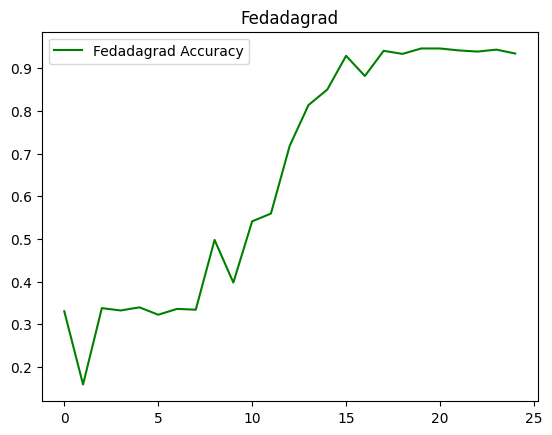

INFO flwr 2023-06-08 16:08:43,198 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)



Analyzing Strategy... :  Fedadam
(launch_and_evaluate pid=66074) [Client 0] evaluate, config: {} [repeated 2x across cluster]


(pid=66075) 2023-06-08 15:41:53.347115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-08 16:08:48,729	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-08 16:08:50,382 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7845548852.0, 'GPU': 1.0, 'object_store_memory': 3922774425.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7845548852.0, 'GPU': 1.0, 'object_store_memory': 3922774425.0}
INFO flwr 2023-06-08 16:08:50,394 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-08 16:08:50,399 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-08 16:08:50,410 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2023-06-08

(launch_and_fit pid=78560) [Client 0] fit, config: {}
(launch_and_fit pid=78560) Epoch 1: train loss 0.025287846103310585, accuracy 0.3834126444595513
(launch_and_fit pid=78561) Epoch 15: train loss 0.004523782525211573, accuracy 0.9048266485384092
(launch_and_fit pid=78561) Epoch 16: train loss 0.004263606853783131, accuracy 0.9068660774983005 [repeated 31x across cluster]
(launch_and_fit pid=78560) Epoch 31: train loss 0.0019592943135648966, accuracy 0.964649898028552 [repeated 29x across cluster]
(launch_and_fit pid=78560) Epoch 39: train loss 0.0014542128192260861, accuracy 0.9755268524813052 [repeated 15x across cluster]
(launch_and_fit pid=78560) [Client 1] fit, config: {}
(launch_and_fit pid=78560) Epoch 3: train loss 0.015523104928433895, accuracy 0.7450713800135962 [repeated 27x across cluster]
(launch_and_fit pid=78561) Epoch 13: train loss 0.0051866937428712845, accuracy 0.8966689326988443
(launch_and_fit pid=78560) Epoch 18: train loss 0.003642058465629816, accuracy 0.92250

DEBUG flwr 2023-06-08 16:09:40,174 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-08 16:09:40,202 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-08 16:09:40,217 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:09:40,500 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-08 16:09:40,514 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-08 16:09:40,516 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_fit pid=78561) Epoch 2: train loss 6.072853088378906, accuracy 0.5173351461590755 [repeated 24x across cluster]
(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 7: train loss 0.0765429213643074, accuracy 0.9503738953093134
(launch_and_fit pid=78561) Epoch 9: train loss 0.07230735570192337, accuracy 0.946974847042828 [repeated 14x across cluster]
(launch_and_fit pid=78560) Epoch 21: train loss 0.0498262383043766, accuracy 0.9578518014955812 [repeated 24x across cluster]
(launch_and_fit pid=78561) Epoch 32: train loss 0.04966406524181366, accuracy 0.9524133242692047 [repeated 22x across cluster]
(launch_and_fit pid=78561) Epoch 39: train loss 0.045809969305992126, accuracy 0.9544527532290958 [repeated 14x across cluster]
(launch_and_fit pid=78561) [Client 0] fit, config: {}
(launch_an

DEBUG flwr 2023-06-08 16:10:35,004 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:10:35,041 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:10:35,276 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:10:35,281 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {}
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_fit pid=78561) Epoch 11: train loss 321.13897705078125, accuracy 0.460231135282121 [repeated 25x across cluster]
(launch_and_evaluate pid=78560) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 14: train loss 261.13494873046875, accuracy 0.4677090414683889
(launch_and_fit pid=78561) Epoch 22: train loss 116.7388687133789, accuracy 0.4724677090414684 [repeated 22x across cluster]
(launch_and_fit pid=78560) Epoch 33: train loss 4.190481662750244, accuracy 0.8470428280081577 [repeated 21x across cluster]
(launch_and_fit pid=78560) Epoch 47: train loss 0.39594566822052, accuracy 0.9354180829367778 [repeated 28x across cluster]
(launch_and_fit pid=78560) [Client 3] fit, config: {}
(launch_and_fit pid=78560) Epoch 8: train loss 390.54779052734375, accuracy 0.47314751869476546 [repeated 22x across cluster]
(launch_and_fi

DEBUG flwr 2023-06-08 16:11:21,359 | server.py:232 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:11:21,387 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:11:21,629 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:11:21,632 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}
(launch_and_fit pid=78561) [Client 0] fit, config: {}
(launch_and_fit pid=78561) Epoch 12: train loss 42.213897705078125, accuracy 0.707681849082257 [repeated 25x across cluster]
(launch_and_evaluate pid=78560) Epoch 14: train loss 29.37984275817871, accuracy 0.7307953772943576
(launch_and_fit pid=78560) Epoch 14: train loss 29.37984275817871, accuracy 0.7307953772943576
(launch_and_fit pid=78560) Epoch 22: train loss 0.6992528438568115, accuracy 0.9082256968048946 [repeated 21x across cluster]
(launch_and_fit pid=78561) Epoch 34: train loss 0.4073590934276581, accuracy 0.9326988443235894 [repeated 21x across cluster]
(launch_and_fit pid=78561) Epoch 48: train loss 0.27437320351600647, accuracy 0.9483344663494222 [repeated 28x across cluster]
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78561) Epoch 8: train loss 79.86028289794922,

DEBUG flwr 2023-06-08 16:12:06,177 | server.py:232 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:12:06,204 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:12:06,440 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:12:06,447 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}
(launch_and_fit pid=78561) [Client 1] fit, config: {}
(launch_and_fit pid=78561) Epoch 1: train loss 528.5186767578125, accuracy 0.13528212100611828 [repeated 16x across cluster]
(launch_and_evaluate pid=78560) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 14: train loss 206.58226013183594, accuracy 0.3161114887831407
(launch_and_fit pid=78560) Epoch 16: train loss 181.93157958984375, accuracy 0.3487423521414004 [repeated 30x across cluster]
(launch_and_fit pid=78561) Epoch 27: train loss 91.7786865234375, accuracy 0.44391570360299115 [repeated 22x across cluster]
(launch_and_fit pid=78561) Epoch 38: train loss 21.84048080444336, accuracy 0.6220258327668253 [repeated 22x across cluster]
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78561) Epoch 2: train loss 487.55694580078125, accuracy 0.1441196464989803 [repeated 28x across cluster]
(launch_and_f

DEBUG flwr 2023-06-08 16:12:50,738 | server.py:232 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:12:50,781 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:12:51,068 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:12:51,071 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78560) Epoch 7: train loss 72.00362396240234, accuracy 0.611148878314072 [repeated 19x across cluster]
(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 13: train loss 29.118980407714844, accuracy 0.6261046906866078
(launch_and_fit pid=78561) Epoch 20: train loss 2.9684665203094482, accuracy 0.8198504418762746 [repeated 27x across cluster]
(launch_and_fit pid=78560) Epoch 31: train loss 0.4134981632232666, accuracy 0.9367777022433719 [repeated 20x across cluster]
(launch_and_fit pid=78561) Epoch 41: train loss 0.33427694439888, accuracy 0.938137321549966 [repeated 22x across cluster]
(launch_and_fit pid=78561) [Client 1] fit, config: {}
(launch_and_fit pid=78561) Epoch 5: train loss 86.55662536621094, accuracy 0.5567641060503059 [repeated 27x across cluster]
(launch_and_fit p

DEBUG flwr 2023-06-08 16:13:35,770 | server.py:232 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:13:35,812 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:13:36,174 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:13:36,180 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_fit pid=78560) [Client 1] fit, config: {}
(launch_and_fit pid=78561) Epoch 10: train loss 33.4634895324707, accuracy 0.5853161114887832 [repeated 20x across cluster]
(launch_and_evaluate pid=78560) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78561) Epoch 13: train loss 19.803245544433594, accuracy 0.7946974847042828
(launch_and_fit pid=78560) Epoch 23: train loss 2.885058641433716, accuracy 0.8932698844323589 [repeated 27x across cluster]
(launch_and_fit pid=78561) Epoch 33: train loss 0.9015159606933594, accuracy 0.9354180829367778 [repeated 19x across cluster]
(launch_and_fit pid=78560) Epoch 44: train loss 0.6576376557350159, accuracy 0.9394969408565602 [repeated 23x across cluster]
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78560) Epoch 7: train loss 59.77995300292969, accuracy 0.5118966689326988 [repeated 26x across cluster]
(launch_and_fi

DEBUG flwr 2023-06-08 16:14:22,184 | server.py:232 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:14:22,223 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=78560) Epoch 50: train loss 0.5517347455024719, accuracy 0.947654656696125 [repeated 18x across cluster]
(launch_and_evaluate pid=78561) [Client 0] evaluate, config: {}


DEBUG flwr 2023-06-08 16:14:22,579 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:14:22,589 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78561) Epoch 11: train loss 118.32623291015625, accuracy 0.4554724677090415 [repeated 21x across cluster]
(launch_and_evaluate pid=78560) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 12: train loss 101.54720306396484, accuracy 0.5227736233854521
(launch_and_fit pid=78561) Epoch 25: train loss 24.045053482055664, accuracy 0.8069340584636302 [repeated 27x across cluster]
(launch_and_fit pid=78561) Epoch 34: train loss 4.723576545715332, accuracy 0.9000679809653297 [repeated 18x across cluster]
(launch_and_fit pid=78561) Epoch 45: train loss 1.2866798639297485, accuracy 0.9354180829367778 [repeated 23x across cluster]
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_fit pid=78560) Epoch 7: train loss 222.27430725097656, accuracy 0.29979605710401086 [repeated 25x across cluster]
(launch_and_fit pid=78560) Epoch 12: train loss 99.6824722290039, accuracy

DEBUG flwr 2023-06-08 16:15:08,175 | server.py:232 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:15:08,209 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:15:08,542 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:15:08,545 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 0] evaluate, config: {}
(launch_and_fit pid=78560) Epoch 50: train loss 1.0617337226867676, accuracy 0.9435757987763427 [repeated 16x across cluster]
(launch_and_fit pid=78561) [Client 1] fit, config: {}
(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78561) Epoch 11: train loss 28.357425689697266, accuracy 0.7851801495581238 [repeated 21x across cluster]
(launch_and_fit pid=78560) Epoch 12: train loss 23.4801082611084, accuracy 0.8096532970768185
(launch_and_fit pid=78560) Epoch 25: train loss 3.459787607192993, accuracy 0.919782460910945 [repeated 28x across cluster]
(launch_and_fit pid=78560) Epoch 35: train loss 1.6392245292663574, accuracy 0.9394969408565602 [repeated 19x across cluster]
(launch_and_fit pid=78561) Epoch 45: train loss 1.4627424478530884, accuracy 0.9401767505098573 [repeated 23x across cluster]
(launch_and_fit pid=78560) [Client 0] fit, config: {}
(launch_and_f

DEBUG flwr 2023-06-08 16:15:53,030 | server.py:232 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:15:53,069 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:15:53,398 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:15:53,407 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {}
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_fit pid=78561) Epoch 2: train loss 90.33771514892578, accuracy 0.5227736233854521 [repeated 16x across cluster]
(launch_and_evaluate pid=78560) Epoch 10: train loss 3.810103178024292, accuracy 0.9129843643779741
(launch_and_fit pid=78560) Epoch 11: train loss 3.3144381046295166, accuracy 0.9184228416043508
(launch_and_fit pid=78561) Epoch 14: train loss 2.5212438106536865, accuracy 0.9313392250169953 [repeated 24x across cluster]
(launch_and_fit pid=78560) Epoch 27: train loss 1.5028941631317139, accuracy 0.9408565601631543 [repeated 27x across cluster]
(launch_and_fit pid=78561) Epoch 37: train loss 1.6278657913208008, accuracy 0.9435757987763427 [repeated 18x across cluster]
(launch_and_fit pid=78560) Epoch 48: train loss 1.1881781816482544, accuracy 0.9483344663494222 [repeated 25x across clu

DEBUG flwr 2023-06-08 16:16:40,630 | server.py:232 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:16:40,663 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:16:40,904 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:16:40,910 | server.py:218 | fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 11: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_fit pid=78561) [Client 0] fit, config: {}
(launch_and_fit pid=78561) Epoch 1: train loss 452.185791015625, accuracy 0.29843643779741674 [repeated 24x across cluster]
(launch_and_evaluate pid=78560) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 8: train loss 221.78350830078125, accuracy 0.6179469748470429
(launch_and_fit pid=78561) Epoch 9: train loss 197.26393127441406, accuracy 0.619986403806934 [repeated 16x across cluster]
(launch_and_fit pid=78560) Epoch 23: train loss 8.845409393310547, accuracy 0.8857919782460911 [repeated 28x across cluster]
(launch_and_fit pid=78560) Epoch 36: train loss 2.3996944427490234, accuracy 0.938817131203263 [repeated 26x across cluster]
(launch_and_fit pid=78561) Epoch 43: train loss 1.5656172037124634, accuracy 0.9422161794697484 [repeated 15x across cluster]
(launch_and_fit pid=78560) [Client 3] fit, config: {}
(launch_and_fit 

DEBUG flwr 2023-06-08 16:17:26,318 | server.py:232 | fit_round 11 received 4 results and 0 failures
DEBUG:flwr:fit_round 11 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:17:26,346 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:17:26,579 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:17:26,589 | server.py:218 | fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 12: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_fit pid=78561) Epoch 4: train loss 262.13372802734375, accuracy 0.5254928619986404 [repeated 24x across cluster]
(launch_and_evaluate pid=78560) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 9: train loss 112.84611511230469, accuracy 0.6301835486063903
(launch_and_fit pid=78560) Epoch 13: train loss 34.873680114746094, accuracy 0.7756628144119646 [repeated 18x across cluster]
(launch_and_fit pid=78561) Epoch 26: train loss 3.717679738998413, accuracy 0.9272603670972128 [repeated 26x across cluster]
(launch_and_fit pid=78561) Epoch 38: train loss 1.9710323810577393, accuracy 0.9449354180829368 [repeated 25x across cluster]
(launch_and_fit pid=78560) Epoch 46: train loss 1.818274736404419, accuracy 0.9530931339225017 [repeated 15x across cluster]
(launch_and_fit pid=78560) [Client 0] fit, config: {}
(launch_and_f

DEBUG flwr 2023-06-08 16:18:12,392 | server.py:232 | fit_round 12 received 4 results and 0 failures
DEBUG:flwr:fit_round 12 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:18:12,423 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:18:12,648 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:18:12,651 | server.py:218 | fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 13: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {}
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_fit pid=78560) Epoch 4: train loss 3.1026177406311035, accuracy 0.9354180829367778 [repeated 21x across cluster]
(launch_and_evaluate pid=78560) Epoch 8: train loss 2.0984580516815186, accuracy 0.9442556084296397
(launch_and_fit pid=78560) Epoch 8: train loss 2.0984580516815186, accuracy 0.9442556084296397
(launch_and_fit pid=78561) Epoch 11: train loss 1.9617668390274048, accuracy 0.9462950373895309 [repeated 15x across cluster]
(launch_and_fit pid=78560) Epoch 25: train loss 1.7084606885910034, accuracy 0.9537729435757988 [repeated 27x across cluster]
(launch_and_fit pid=78560) Epoch 38: train loss 1.509777545928955, accuracy 0.9578518014955812 [repeated 26x across cluster]
(launch_and_fit pid=78561) Epoch 45: train loss 1.4095646142959595, accuracy 0.95581237253569 [repeated 15x across cluste

DEBUG flwr 2023-06-08 16:18:59,014 | server.py:232 | fit_round 13 received 4 results and 0 failures
DEBUG:flwr:fit_round 13 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:18:59,044 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:18:59,258 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:18:59,265 | server.py:218 | fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 14: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78561) Epoch 3: train loss 116.63851928710938, accuracy 0.6954452753229096 [repeated 24x across cluster]
(launch_and_evaluate pid=78560) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 8: train loss 45.02592468261719, accuracy 0.8470428280081577
(launch_and_fit pid=78561) Epoch 11: train loss 26.434696197509766, accuracy 0.8755948334466349 [repeated 16x across cluster]
(launch_and_fit pid=78561) Epoch 24: train loss 2.128161907196045, accuracy 0.9537729435757988 [repeated 27x across cluster]
(launch_and_fit pid=78561) Epoch 37: train loss 1.2994023561477661, accuracy 0.9578518014955812 [repeated 25x across cluster]
(launch_and_fit pid=78561) Epoch 45: train loss 1.2167909145355225, accuracy 0.9585316111488783 [repeated 16x across cluster]
(launch_and_fit pid=78561) [Client 1] fit, config: {}
(launch_and_f

DEBUG flwr 2023-06-08 16:19:44,882 | server.py:232 | fit_round 14 received 4 results and 0 failures
DEBUG:flwr:fit_round 14 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:19:44,925 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:19:45,138 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:19:45,149 | server.py:218 | fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 15: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {}
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78560) Epoch 3: train loss 177.1691131591797, accuracy 0.7559483344663495 [repeated 22x across cluster]
(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 8: train loss 103.47081756591797, accuracy 0.8212100611828688
(launch_and_fit pid=78561) Epoch 10: train loss 75.97073364257812, accuracy 0.8416043507817811 [repeated 15x across cluster]
(launch_and_fit pid=78561) Epoch 24: train loss 4.55340576171875, accuracy 0.9462950373895309 [repeated 27x across cluster]
(launch_and_fit pid=78560) Epoch 36: train loss 1.7792861461639404, accuracy 0.9639700883752549 [repeated 25x across cluster]
(launch_and_fit pid=78560) Epoch 43: train loss 1.6227070093154907, accuracy 0.9626104690686608 [repeated 14x across cluster]
(launch_and_fit pid=78561) [Client 0] fit, config: {}
(launch_and_fit

DEBUG flwr 2023-06-08 16:20:32,449 | server.py:232 | fit_round 15 received 4 results and 0 failures
DEBUG:flwr:fit_round 15 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:20:32,480 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:20:32,714 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:20:32,726 | server.py:218 | fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 16: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78561) Epoch 50: train loss 1.0496277809143066, accuracy 0.9673691366417403 [repeated 24x across cluster]
(launch_and_evaluate pid=78560) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 7: train loss 16.830102920532227, accuracy 0.9218218898708361
(launch_and_fit pid=78560) Epoch 7: train loss 16.830102920532227, accuracy 0.9218218898708361 [repeated 14x across cluster]
(launch_and_fit pid=78561) Epoch 21: train loss 1.3794158697128296, accuracy 0.9612508497620667 [repeated 27x across cluster]
(launch_and_fit pid=78561) Epoch 34: train loss 1.0571694374084473, accuracy 0.9653297076818491 [repeated 26x across cluster]
(launch_and_fit pid=78561) Epoch 41: train loss 0.9926565289497375, accuracy 0.9653297076818491 [repeated 14x across cluster]
(launch_and_fit pid=78560) [Client 1] fit, config: {}
(launch_and

DEBUG flwr 2023-06-08 16:21:19,479 | server.py:232 | fit_round 16 received 4 results and 0 failures
DEBUG:flwr:fit_round 16 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:21:19,526 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:21:19,885 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:21:19,893 | server.py:218 | fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 17: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_fit pid=78561) Epoch 50: train loss 1.3645424842834473, accuracy 0.9687287559483345 [repeated 25x across cluster]
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 7: train loss 7.043573379516602, accuracy 0.9265805574439157 [repeated 13x across cluster]
(launch_and_fit pid=78560) Epoch 8: train loss 4.841911315917969, accuracy 0.9306594153636981
(launch_and_fit pid=78561) Epoch 20: train loss 1.4969526529312134, accuracy 0.9626104690686608 [repeated 26x across cluster]
(launch_and_fit pid=78560) Epoch 33: train loss 1.2213242053985596, accuracy 0.9660095173351462 [repeated 26x across cluster]
(launch_and_fit pid=78561) Epoch 40: train loss 1.3222298622131348, accuracy 0.9687287559483345 [repeated 15x across cluster]
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_f

DEBUG flwr 2023-06-08 16:22:09,829 | server.py:232 | fit_round 17 received 4 results and 0 failures
DEBUG:flwr:fit_round 17 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:22:09,865 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:22:10,212 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:22:10,221 | server.py:218 | fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 18: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78561) Epoch 2: train loss 392.1077575683594, accuracy 0.5472467709041469 [repeated 15x across cluster]
(launch_and_evaluate pid=78560) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 11: train loss 44.25066375732422, accuracy 0.8368456832087016
(launch_and_fit pid=78560) Epoch 15: train loss 15.6777982711792, accuracy 0.9157036029911625 [repeated 26x across cluster]
(launch_and_fit pid=78560) Epoch 29: train loss 2.2710132598876953, accuracy 0.95581237253569 [repeated 28x across cluster]
(launch_and_fit pid=78561) Epoch 37: train loss 1.2485092878341675, accuracy 0.9626104690686608 [repeated 16x across cluster]
(launch_and_fit pid=78561) [Client 0] fit, config: {}
(launch_and_fit pid=78561) Epoch 1: train loss 450.1063537597656, accuracy 0.5098572399728076 [repeated 27x across cluster]
(launch_and_fit pi

DEBUG flwr 2023-06-08 16:22:54,296 | server.py:232 | fit_round 18 received 4 results and 0 failures
DEBUG:flwr:fit_round 18 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:22:54,324 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:22:54,679 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:22:54,687 | server.py:218 | fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 19: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {}
(launch_and_fit pid=78561) [Client 1] fit, config: {}
(launch_and_fit pid=78561) Epoch 6: train loss 86.35015106201172, accuracy 0.7647858599592114 [repeated 14x across cluster]
(launch_and_evaluate pid=78560) Epoch 9: train loss 36.78820037841797, accuracy 0.8545207341944255
(launch_and_fit pid=78560) Epoch 10: train loss 28.243898391723633, accuracy 0.8796736913664174
(launch_and_fit pid=78561) Epoch 20: train loss 4.101919651031494, accuracy 0.9496940856560163 [repeated 28x across cluster]
(launch_and_fit pid=78561) Epoch 33: train loss 1.0378254652023315, accuracy 0.9687287559483345 [repeated 26x across cluster]
(launch_and_fit pid=78561) Epoch 42: train loss 0.8186466693878174, accuracy 0.973487423521414 [repeated 17x across cluster]
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_fit pid=78560) Epoch 5: train loss 121.2081069946289, acc

DEBUG flwr 2023-06-08 16:23:38,534 | server.py:232 | fit_round 19 received 4 results and 0 failures
DEBUG:flwr:fit_round 19 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:23:38,562 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:23:38,868 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:23:38,873 | server.py:218 | fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 20: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78560) Epoch 1: train loss 65.73282623291016, accuracy 0.752549286199864 [repeated 22x across cluster]
(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 8: train loss 0.9340261220932007, accuracy 0.9707681849082257
(launch_and_fit pid=78561) Epoch 10: train loss 0.836118757724762, accuracy 0.9721278042148198 [repeated 17x across cluster]
(launch_and_fit pid=78561) Epoch 24: train loss 0.6633456945419312, accuracy 0.9741672331747111 [repeated 28x across cluster]
(launch_and_fit pid=78561) Epoch 36: train loss 0.5806599855422974, accuracy 0.9768864717878993 [repeated 25x across cluster]
(launch_and_fit pid=78561) Epoch 46: train loss 0.5004318356513977, accuracy 0.9775662814411965 [repeated 20x across cluster]
(launch_and_fit pid=78560) [Client 0] fit, config: {}
(launch_and_fi

DEBUG flwr 2023-06-08 16:24:23,809 | server.py:232 | fit_round 20 received 4 results and 0 failures
DEBUG:flwr:fit_round 20 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:24:23,840 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:24:24,053 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:24:24,062 | server.py:218 | fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 21: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_fit pid=78561) Epoch 4: train loss 36.60105895996094, accuracy 0.8973487423521413 [repeated 18x across cluster]
(launch_and_evaluate pid=78560) Epoch 7: train loss 18.100460052490234, accuracy 0.9259007477906186
(launch_and_fit pid=78560) Epoch 8: train loss 13.48855209350586, accuracy 0.9326988443235894
(launch_and_fit pid=78560) Epoch 15: train loss 1.8993983268737793, accuracy 0.9687287559483345 [repeated 21x across cluster]
(launch_and_fit pid=78561) Epoch 28: train loss 1.676770806312561, accuracy 0.9809653297076818 [repeated 27x across cluster]
(launch_and_fit pid=78561) Epoch 38: train loss 1.458253264427185, accuracy 0.9796057104010877 [repeated 20x across cluster]
(launch_and_fit pid=78561) Epoch 49: train loss 1.3776766061782837, accuracy 0.981645139360979 [repeated 22x across cluster]

DEBUG flwr 2023-06-08 16:25:09,297 | server.py:232 | fit_round 21 received 4 results and 0 failures
DEBUG:flwr:fit_round 21 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:25:09,334 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:25:09,549 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:25:09,557 | server.py:218 | fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 22: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}
(launch_and_fit pid=78561) [Client 1] fit, config: {}
(launch_and_fit pid=78560) Epoch 6: train loss 56.891395568847656, accuracy 0.8959891230455472 [repeated 17x across cluster]
(launch_and_evaluate pid=78560) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 8: train loss 38.53302001953125, accuracy 0.9157036029911625
(launch_and_fit pid=78561) Epoch 17: train loss 5.711724758148193, accuracy 0.9571719918422842 [repeated 23x across cluster]
(launch_and_fit pid=78561) Epoch 31: train loss 0.8393588066101074, accuracy 0.9775662814411965 [repeated 28x across cluster]
(launch_and_fit pid=78560) Epoch 41: train loss 1.5370936393737793, accuracy 0.9768864717878993 [repeated 19x across cluster]
(launch_and_fit pid=78560) [Client 0] fit, config: {}
(launch_and_fit pid=78561) Epoch 2: train loss 132.15615844726562, accuracy 0.7593473827328348 [repeated 23x across cluster]
(launch_and_fi

DEBUG flwr 2023-06-08 16:25:54,936 | server.py:232 | fit_round 22 received 4 results and 0 failures
DEBUG:flwr:fit_round 22 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:25:54,968 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 22: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:25:55,188 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:25:55,193 | server.py:218 | fit_round 23: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 23: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=78561) Epoch 50: train loss 0.6628251075744629, accuracy 0.972807613868117 [repeated 27x across cluster]
(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=78561) [Client 0] evaluate, config: {}
(launch_and_fit pid=78561) [Client 3] fit, config: {}
(launch_and_fit pid=78561) Epoch 8: train loss 7.6584625244140625, accuracy 0.9524133242692047 [repeated 16x across cluster]
(launch_and_evaluate pid=78560) Epoch 8: train loss 7.6584625244140625, accuracy 0.9524133242692047
(launch_and_fit pid=78560) Epoch 9: train loss 6.0109381675720215, accuracy 0.9564921821889871
(launch_and_fit pid=78561) Epoch 20: train loss 1.0573222637176514, accuracy 0.9755268524813052 [repeated 25x across cluster]
(launch_and_fit pid=78561) Epoch 34: train loss 0.6261327862739563, accuracy 0.9748470428280082 [repeated 27x across cluster]
(launch_and_fit pid=78561) Epoch 43: train loss 0.5748609304428101, accuracy 0.9782460910944936 [repeated 18x across clus

DEBUG flwr 2023-06-08 16:26:40,241 | server.py:232 | fit_round 23 received 4 results and 0 failures
DEBUG:flwr:fit_round 23 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:26:40,272 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 23: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:26:40,517 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:26:40,525 | server.py:218 | fit_round 24: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 24: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {}
(launch_and_fit pid=78561) [Client 0] fit, config: {}
(launch_and_fit pid=78561) Epoch 1: train loss 17.615861892700195, accuracy 0.8048946295037389 [repeated 24x across cluster]
(launch_and_evaluate pid=78561) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=78560) Epoch 9: train loss 0.6531000137329102, accuracy 0.9782460910944936
(launch_and_fit pid=78560) Epoch 10: train loss 1.2250205278396606, accuracy 0.9762066621346023 [repeated 17x across cluster]
(launch_and_fit pid=78561) Epoch 22: train loss 0.38493674993515015, accuracy 0.9802855200543847 [repeated 25x across cluster]
(launch_and_fit pid=78561) 
(launch_and_fit pid=78561) Epoch 36: train loss 0.34340527653694153, accuracy 0.9802855200543847 [repeated 27x across cluster]
(launch_and_fit pid=78561) Epoch 44: train loss 0.3183104693889618, accuracy 0.981645139360979 [repeated 17x across cluster]
(launch_and_fit pid=78560) [Client 3

DEBUG flwr 2023-06-08 16:27:28,246 | server.py:232 | fit_round 24 received 4 results and 0 failures
DEBUG:flwr:fit_round 24 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:27:28,279 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 24: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=78561) Epoch 50: train loss 0.36056533455848694, accuracy 0.9836845683208701 [repeated 28x across cluster]


DEBUG flwr 2023-06-08 16:27:28,509 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:27:28,517 | server.py:218 | fit_round 25: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 25: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=78561) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_fit pid=78561) [Client 2] fit, config: {}
(launch_and_fit pid=78561) Epoch 8: train loss 22.170242309570312, accuracy 0.9184228416043508 [repeated 17x across cluster]
(launch_and_evaluate pid=78560) Epoch 9: train loss 16.86380958557129, accuracy 0.9320190346702923
(launch_and_fit pid=78560) Epoch 9: train loss 16.86380958557129, accuracy 0.9320190346702923
(launch_and_fit pid=78561) Epoch 19: train loss 2.348238468170166, accuracy 0.9694085656016316 [repeated 22x across cluster]
(launch_and_fit pid=78560) Epoch 34: train loss 0.5359553098678589, accuracy 0.9809653297076818 [repeated 28x across cluster]
(launch_and_fit pid=78561) Epoch 43: train loss 0.8958625793457031, accuracy 0.9850441876274643 [repeated 21x across cluster]
(launch_and_fit pid=78560) [Client 3] fit, config: {}
(launch_and_fit pid=78561) Epoch 4: train loss 77.2509536743164, accu

DEBUG flwr 2023-06-08 16:28:13,397 | server.py:232 | fit_round 25 received 4 results and 0 failures
DEBUG:flwr:fit_round 25 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:28:13,447 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 25: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:28:13,696 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 3 results and 0 failures
INFO flwr 2023-06-08 16:28:13,703 | server.py:147 | FL finished in 1163.2844899850006
INFO:flwr:FL finished in 1163.2844899850006
INFO flwr 2023-06-08 16:28:13,704 | app.py:218 | app_fit: losses_distributed [(1, 0.3378746594005449), (2, 0.3369663941871026), (3, 0.3369663941871026), (4, 0.13714804722979113), (5, 0.13714804722979113), (6, 0.477747502270663), (7, 0.16167120799273388), (8, 0.4613987284287011), (9, 0.4822888283378746), (10, 0.3088101725703905), (11, 0.31335149863760214), (12, 0.7

(launch_and_evaluate pid=78561) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=78561) [Client 1] evaluate, config: {}


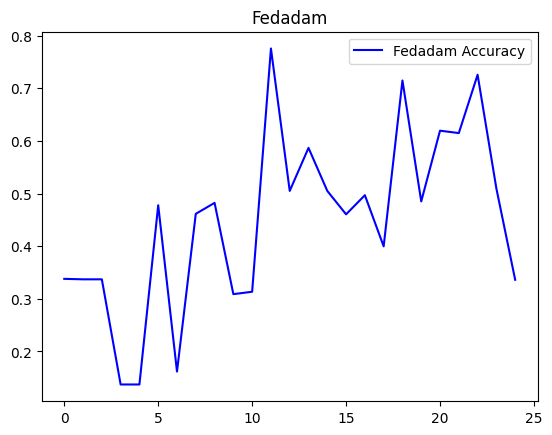

INFO flwr 2023-06-08 16:28:14,276 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)



Analyzing Strategy... :  Fedyogi
(launch_and_fit pid=78561) Epoch 50: train loss 0.30116066336631775, accuracy 0.9830047586675731 [repeated 21x across cluster]
(launch_and_evaluate pid=78560) [Client 0] evaluate, config: {}


(pid=78561) 2023-06-08 16:08:52.757996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-08 16:28:20,431	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-08 16:28:22,108 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7845467751.0, 'object_store_memory': 3922733875.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7845467751.0, 'object_store_memory': 3922733875.0}
INFO flwr 2023-06-08 16:28:22,122 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-08 16:28:22,125 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-08 16:28:22,130 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2023-06-08

(launch_and_fit pid=89122) [Client 0] fit, config: {}
(launch_and_fit pid=89122) Epoch 1: train loss 0.025299381464719772, accuracy 0.469068660774983
(launch_and_fit pid=89121) Epoch 9: train loss 0.007121688220649958, accuracy 0.849082256968049
(launch_and_fit pid=89122) Epoch 10: train loss 0.006558872759342194, accuracy 0.8626784500339905 [repeated 18x across cluster]
(launch_and_fit pid=89121) Epoch 25: train loss 0.0026019816286861897, accuracy 0.9524133242692047 [repeated 31x across cluster]
(launch_and_fit pid=89122) Epoch 40: train loss 0.0014654999831691384, accuracy 0.9768864717878993 [repeated 29x across cluster]
(launch_and_fit pid=89122) Epoch 48: train loss 0.0011576071847230196, accuracy 0.9809653297076818 [repeated 16x across cluster]
(launch_and_fit pid=89122) [Client 1] fit, config: {}
(launch_and_fit pid=89122) Epoch 13: train loss 0.005140591878443956, accuracy 0.8898708361658736 [repeated 30x across cluster]
(launch_and_fit pid=89121) Epoch 16: train loss 0.0041932

DEBUG flwr 2023-06-08 16:29:10,957 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-08 16:29:10,982 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-08 16:29:10,999 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=89121) Epoch 50: train loss 0.0011559062404558063, accuracy 0.9755268524813052 [repeated 28x across cluster]


DEBUG flwr 2023-06-08 16:29:11,280 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-06-08 16:29:11,285 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-08 16:29:11,292 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_fit pid=89122) [Client 3] fit, config: {}
(launch_and_fit pid=89121) Epoch 13: train loss 0.002757374197244644, accuracy 0.9564921821889871 [repeated 26x across cluster]
(launch_and_evaluate pid=89122) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89121) Epoch 14: train loss 0.0026006654370576143, accuracy 0.9605710401087696
(launch_and_fit pid=89121) Epoch 23: train loss 0.0016778614372015, accuracy 0.9741672331747111 [repeated 20x across cluster]
(launch_and_fit pid=89122) Epoch 38: train loss 0.0010851917322725058, accuracy 0.9775662814411965 [repeated 30x across cluster]
(launch_and_fit pid=89121) [Client 1] fit, config: {}
(launch_and_fit pid=89122) Epoch 1: train loss 0.009583162143826485, accuracy 0.8959891230455472 [repeated 26x across cluster]
(launch_and_fit pid=89122) Epoch 9: train loss 0.0034996126778423786, accuracy 0.9313392250169953
(launch_and_fit pid=89122) E

DEBUG flwr 2023-06-08 16:29:52,086 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:29:52,116 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 4)


(launch_and_fit pid=89122) Epoch 49: train loss 0.0007604471757076681, accuracy 0.9870836165873556 [repeated 17x across cluster]


DEBUG flwr 2023-06-08 16:29:52,346 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:29:52,351 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 2] evaluate, config: {}
(launch_and_fit pid=89122) [Client 3] fit, config: {}
(launch_and_fit pid=89122) Epoch 14: train loss 0.0012508536456152797, accuracy 0.9768864717878993 [repeated 29x across cluster]
(launch_and_evaluate pid=89121) Epoch 15: train loss 0.0012149056419730186, accuracy 0.9768864717878993
(launch_and_fit pid=89121) Epoch 16: train loss 0.0011802013032138348, accuracy 0.9775662814411965
(launch_and_fit pid=89122) Epoch 29: train loss 0.0008623242611065507, accuracy 0.9809653297076818 [repeated 30x across cluster]
(launch_and_fit pid=89122) Epoch 39: train loss 0.0007138351793400943, accuracy 0.9864038069340585 [repeated 20x across cluster]
(launch_and_fit pid=89122) [Client 0] fit, config: {}
(launch_and_fit pid=89121) Epoch 4: train loss 0.0017683159094303846, accuracy 0.9687287559483345 [repeated 31x across cluster]
(launch_and_fit pid=89121) Epoch 15: train los

DEBUG flwr 2023-06-08 16:30:30,152 | server.py:232 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:30:30,189 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:30:30,432 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:30:30,436 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 3] evaluate, config: {}
(launch_and_fit pid=89122) [Client 3] fit, config: {}
(launch_and_fit pid=89122) Epoch 7: train loss 0.0009281127131544054, accuracy 0.9782460910944936 [repeated 27x across cluster]
(launch_and_evaluate pid=89121) Epoch 11: train loss 0.0008497678791172802, accuracy 0.982324949014276
(launch_and_fit pid=89121) Epoch 11: train loss 0.0008497678791172802, accuracy 0.982324949014276
(launch_and_fit pid=89122) Epoch 16: train loss 0.0007816603174433112, accuracy 0.982324949014276 [repeated 18x across cluster]
(launch_and_fit pid=89121) Epoch 31: train loss 0.0007385700009763241, accuracy 0.9782460910944936 [repeated 31x across cluster]
(launch_and_fit pid=89121) Epoch 46: train loss 0.0007762113818898797, accuracy 0.982324949014276 [repeated 30x across cluster]
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89122) Epoch 5: train loss 0.0

DEBUG flwr 2023-06-08 16:31:10,554 | server.py:232 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:31:10,584 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:31:10,819 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:31:10,828 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 3] evaluate, config: {}
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89121) Epoch 8: train loss 0.0010673515498638153, accuracy 0.9796057104010877 [repeated 27x across cluster]
(launch_and_evaluate pid=89121) Epoch 15: train loss 0.0007116881315596402, accuracy 0.9850441876274643
(launch_and_fit pid=89121) Epoch 15: train loss 0.0007116881315596402, accuracy 0.9850441876274643
(launch_and_fit pid=89122) Epoch 23: train loss 0.0007884644437581301, accuracy 0.9802855200543847 [repeated 29x across cluster]
(launch_and_fit pid=89121) Epoch 32: train loss 0.001128694973886013, accuracy 0.9748470428280082 [repeated 18x across cluster]
(launch_and_fit pid=89121) Epoch 48: train loss 0.0010986095294356346, accuracy 0.973487423521414 [repeated 31x across cluster]
(launch_and_fit pid=89121) [Client 0] fit, config: {}
(launch_and_fit pid=89121) Epoch 13: train loss 

DEBUG flwr 2023-06-08 16:31:49,111 | server.py:232 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:31:49,141 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:31:49,414 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:31:49,420 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 3] evaluate, config: {}
(launch_and_fit pid=89122) Epoch 50: train loss 0.0004480370262172073, accuracy 0.990482664853841 [repeated 28x across cluster]
(launch_and_fit pid=89122) [Client 3] fit, config: {}
(launch_and_evaluate pid=89122) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89122) Epoch 7: train loss 0.0020470181480050087, accuracy 0.9694085656016316 [repeated 13x across cluster]
(launch_and_fit pid=89121) Epoch 8: train loss 0.001225458923727274, accuracy 0.9802855200543847
(launch_and_fit pid=89122) Epoch 20: train loss 0.0018175099976360798, accuracy 0.9748470428280082 [repeated 28x across cluster]
(launch_and_fit pid=89121) Epoch 35: train loss 0.0006838636472821236, accuracy 0.9884432358939497 [repeated 27x across cluster]
(launch_and_fit pid=89122) Epoch 41: train loss 0.000548963260371238, accuracy 0.991162474507138 [repeated 15x across cluster]
(launch_and_fit pid=89121) [Client 1] fit, config: 

DEBUG flwr 2023-06-08 16:32:37,421 | server.py:232 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:32:37,470 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:32:37,798 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:32:37,804 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89122) Epoch 4: train loss 0.002349560847505927, accuracy 0.973487423521414 [repeated 12x across cluster]
(launch_and_evaluate pid=89121) Epoch 7: train loss 0.0028649638406932354, accuracy 0.9653297076818491
(launch_and_fit pid=89121) Epoch 8: train loss 0.003085975768044591, accuracy 0.964649898028552
(launch_and_fit pid=89122) Epoch 15: train loss 0.0010663711000233889, accuracy 0.9850441876274643 [repeated 19x across cluster]
(launch_and_fit pid=89122) Epoch 25: train loss 0.00037290112231858075, accuracy 0.9952413324269205 [repeated 18x across cluster]
(launch_and_fit pid=89122) Epoch 33: train loss 0.00029482951504178345, accuracy 0.9959211420802175 [repeated 14x across cluster]
(launch_and_fit pid=89122) Epoch 44: train loss 0.00020203078747726977, accuracy 0.9966009517335146 [rep

DEBUG flwr 2023-06-08 16:33:41,840 | server.py:232 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:33:41,869 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:33:42,100 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:33:42,109 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89121) Epoch 2: train loss 0.0010588612640276551, accuracy 0.9843643779741672 [repeated 11x across cluster]
(launch_and_evaluate pid=89121) Epoch 6: train loss 0.0011311224661767483, accuracy 0.9830047586675731
(launch_and_fit pid=89121) Epoch 7: train loss 0.0013340205186977983, accuracy 0.9809653297076818
(launch_and_fit pid=89122) Epoch 10: train loss 0.00087843177607283, accuracy 0.9864038069340585 [repeated 14x across cluster]
(launch_and_fit pid=89122) Epoch 14: train loss 0.0003531710826791823, accuracy 0.9945615227736234 [repeated 8x across cluster]
(launch_and_fit pid=89121) Epoch 19: train loss 0.0011750609846785665, accuracy 0.9789259007477906 [repeated 13x across cluster]
(launch_and_fit pid=89121) Epoch 26: train loss 0.0017849766882136464, accuracy 0.9755268524813052 [repea

DEBUG flwr 2023-06-08 16:35:12,734 | server.py:232 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:35:12,764 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:35:12,976 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:35:12,982 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 0] evaluate, config: {}
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89122) Epoch 2: train loss 0.0013919182820245624, accuracy 0.981645139360979 [repeated 10x across cluster]
(launch_and_evaluate pid=89121) Epoch 6: train loss 0.0008945684530772269, accuracy 0.9864038069340585
(launch_and_fit pid=89121) Epoch 6: train loss 0.0008945684530772269, accuracy 0.9864038069340585
(launch_and_fit pid=89122) Epoch 8: train loss 0.000777930545154959, accuracy 0.9891230455472467 [repeated 12x across cluster]
(launch_and_fit pid=89121) Epoch 11: train loss 0.001188754104077816, accuracy 0.981645139360979 [repeated 7x across cluster]
(launch_and_fit pid=89121) Epoch 17: train loss 0.0016273920191451907, accuracy 0.9748470428280082 [repeated 12x across cluster]
(launch_and_fit pid=89122) Epoch 24: train loss 0.0002087086468236521, accuracy 0.9959211420802175 [repeated

DEBUG flwr 2023-06-08 16:36:59,685 | server.py:232 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:36:59,718 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:36:59,949 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:36:59,953 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=89121) Epoch 50: train loss 0.00013394595589488745, accuracy 0.9972807613868117 [repeated 12x across cluster]
(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89121) Epoch 5: train loss 0.0007864237413741648, accuracy 0.9898028552005439 [repeated 10x across cluster]
(launch_and_evaluate pid=89121) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89121) Epoch 6: train loss 0.0003838005068246275, accuracy 0.9952413324269205
(launch_and_fit pid=89122) Epoch 9: train loss 0.00025364605244249105, accuracy 0.9966009517335146 [repeated 7x across cluster]
(launch_and_fit pid=89122) Epoch 15: train loss 0.00014450063463300467, accuracy 0.9966009517335146 [repeated 12x across cluster]
(launch_and_fit pid=89122) Epoch 20: train loss 0.0004930717404931784, accuracy 0.990482664853841 [repeated 10x across cluster]
(launch_and_fit pid=89121) Epoch 24: train loss

DEBUG flwr 2023-06-08 16:38:48,645 | server.py:232 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:38:48,681 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:38:48,964 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:38:48,972 | server.py:218 | fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 11: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 3] evaluate, config: {}
(launch_and_fit pid=89122) [Client 3] fit, config: {}
(launch_and_fit pid=89121) Epoch 50: train loss 6.400852726073936e-05, accuracy 0.9993201903467029 [repeated 11x across cluster]
(launch_and_evaluate pid=89121) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89121) Epoch 4: train loss 0.0007772202370688319, accuracy 0.9850441876274643
(launch_and_fit pid=89121) Epoch 4: train loss 0.0007772202370688319, accuracy 0.9850441876274643 [repeated 7x across cluster]
(launch_and_fit pid=89121) Epoch 11: train loss 0.0006866742623969913, accuracy 0.9850441876274643 [repeated 13x across cluster]
(launch_and_fit pid=89121) Epoch 16: train loss 0.000745854340493679, accuracy 0.9850441876274643 [repeated 10x across cluster]
(launch_and_fit pid=89122) Epoch 19: train loss 0.00010276032116962597, accuracy 0.9972807613868117 [repeated 9x across cluster]
(launch_and_fit pid=89121) Epoch 27: train loss 0

DEBUG flwr 2023-06-08 16:40:31,853 | server.py:232 | fit_round 11 received 4 results and 0 failures
DEBUG:flwr:fit_round 11 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:40:31,888 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 11: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:40:32,108 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:40:32,116 | server.py:218 | fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 12: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89122) Epoch 2: train loss 0.0007442830828949809, accuracy 0.9870836165873556 [repeated 11x across cluster]
(launch_and_evaluate pid=89121) Epoch 4: train loss 0.00021680325153283775, accuracy 0.9966009517335146
(launch_and_fit pid=89121) Epoch 4: train loss 0.00033700416679494083, accuracy 0.9938817131203264
(launch_and_fit pid=89122) Epoch 6: train loss 0.0001323256001342088, accuracy 0.9972807613868117 [repeated 7x across cluster]
(launch_and_fit pid=89121) Epoch 11: train loss 0.0001281517033930868, accuracy 0.9972807613868117 [repeated 13x across cluster]
(launch_and_fit pid=89122) Epoch 19: train loss 0.0003018668794538826, accuracy 0.9938817131203264 [repeated 12x across cluster]
(launch_and_fit pid=89121) Epoch 21: train loss 7.736583211226389e-05, accuracy 0.9979605710401088 [re

DEBUG flwr 2023-06-08 16:42:12,815 | server.py:232 | fit_round 12 received 4 results and 0 failures
DEBUG:flwr:fit_round 12 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:42:12,852 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 12: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:42:13,073 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:42:13,080 | server.py:218 | fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 13: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 0] evaluate, config: {}
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89121) Epoch 2: train loss 0.0006403539446182549, accuracy 0.9877634262406526 [repeated 9x across cluster]
(launch_and_evaluate pid=89121) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89121) Epoch 7: train loss 8.888870797818527e-05, accuracy 0.9979605710401088
(launch_and_fit pid=89122) Epoch 8: train loss 0.00013120997755322605, accuracy 0.9966009517335146 [repeated 11x across cluster]
(launch_and_fit pid=89122) Epoch 13: train loss 0.0023274067789316177, accuracy 0.9762066621346023 [repeated 9x across cluster]
(launch_and_fit pid=89122) Epoch 20: train loss 2.0645260519813746e-05, accuracy 1.0 [repeated 14x across cluster]
(launch_and_fit pid=89121) Epoch 23: train loss 8.490285836160183e-05, accuracy 0.9986403806934059 [repeated 10x across cluster]
(launch_and_fit pid=89122) Epoch 29: train loss 1.2623243492271

DEBUG flwr 2023-06-08 16:43:53,985 | server.py:232 | fit_round 13 received 4 results and 0 failures
DEBUG:flwr:fit_round 13 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:43:54,048 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 13: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:43:54,406 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:43:54,409 | server.py:218 | fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 14: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 2] evaluate, config: {}
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89122) Epoch 1: train loss 0.0012261781375855207, accuracy 0.9877634262406526 [repeated 5x across cluster]
(launch_and_evaluate pid=89121) Epoch 5: train loss 0.00043854062096215785, accuracy 0.9877634262406526
(launch_and_fit pid=89121) Epoch 6: train loss 0.00037542395875789225, accuracy 0.9918422841604351
(launch_and_fit pid=89121) Epoch 8: train loss 0.00038449186831712723, accuracy 0.991162474507138 [repeated 13x across cluster]
(launch_and_fit pid=89121) Epoch 14: train loss 0.0006000269786454737, accuracy 0.9864038069340585 [repeated 12x across cluster]
(launch_and_fit pid=89121) Epoch 18: train loss 0.000231789774261415, accuracy 0.9945615227736234 [repeated 8x across cluster]
(launch_and_fit pid=89122) Epoch 24: train loss 6.346517329802737e-05, accuracy 0.9979605710401088 [repe

DEBUG flwr 2023-06-08 16:45:32,434 | server.py:232 | fit_round 14 received 4 results and 0 failures
DEBUG:flwr:fit_round 14 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:45:32,463 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 14: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:45:32,688 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:45:32,694 | server.py:218 | fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 15: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 3] evaluate, config: {}
(launch_and_fit pid=89122) [Client 0] fit, config: {}
(launch_and_fit pid=89121) Epoch 1: train loss 0.0004008332616649568, accuracy 0.9938817131203264 [repeated 9x across cluster]
(launch_and_evaluate pid=89121) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89121) Epoch 6: train loss 0.00031856700661592185, accuracy 0.9925220938137321
(launch_and_fit pid=89121) Epoch 6: train loss 0.00031856700661592185, accuracy 0.9925220938137321 [repeated 10x across cluster]
(launch_and_fit pid=89122) Epoch 11: train loss 0.00027735784533433616, accuracy 0.9918422841604351 [repeated 10x across cluster]
(launch_and_fit pid=89122) Epoch 18: train loss 0.0005724797956645489, accuracy 0.9843643779741672 [repeated 14x across cluster]
(launch_and_fit pid=89121) Epoch 22: train loss 6.590832981601125e-06, accuracy 1.0 [repeated 9x across cluster]
(launch_and_fit pid=89122) Epoch 29: train loss 9.779801621334

DEBUG flwr 2023-06-08 16:47:08,246 | server.py:232 | fit_round 15 received 4 results and 0 failures
DEBUG:flwr:fit_round 15 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:47:08,286 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 15: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:47:08,628 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:47:08,633 | server.py:218 | fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 16: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_fit pid=89121) Epoch 50: train loss 3.4931167647300754e-06, accuracy 1.0 [repeated 9x across cluster]
(launch_and_fit pid=89122) [Client 0] fit, config: {}
(launch_and_evaluate pid=89121) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89122) Epoch 5: train loss 0.0001439487241441384, accuracy 0.9945615227736234 [repeated 10x across cluster]
(launch_and_fit pid=89121) Epoch 6: train loss 0.00016555501497350633, accuracy 0.9952413324269205
(launch_and_fit pid=89121) Epoch 12: train loss 1.040766710502794e-05, accuracy 1.0 [repeated 13x across cluster]
(launch_and_fit pid=89122) Epoch 16: train loss 0.0004230598278809339, accuracy 0.9877634262406526 [repeated 9x across cluster]
(launch_and_fit pid=89122) Epoch 23: train loss 0.0011373991146683693, accuracy 0.9864038069340585 [repeated 14x across cluster]
(launch_and_fit pid=89122) Epoch 29: train loss 3.7058405723655596e-05, accur

DEBUG flwr 2023-06-08 16:48:45,573 | server.py:232 | fit_round 16 received 4 results and 0 failures
DEBUG:flwr:fit_round 16 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:48:45,603 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 16: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:48:45,836 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:48:45,841 | server.py:218 | fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 17: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=89122) Epoch 50: train loss 2.973289383589872e-06, accuracy 1.0 [repeated 9x across cluster]
(launch_and_evaluate pid=89122) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 2] evaluate, config: {}
(launch_and_fit pid=89122) [Client 0] fit, config: {}
(launch_and_fit pid=89122) Epoch 6: train loss 0.0001556242787046358, accuracy 0.9959211420802175 [repeated 12x across cluster]
(launch_and_evaluate pid=89121) Epoch 6: train loss 0.0001556242787046358, accuracy 0.9959211420802175
(launch_and_fit pid=89121) Epoch 6: train loss 0.0001556242787046358, accuracy 0.9959211420802175
(launch_and_fit pid=89122) Epoch 11: train loss 0.00017972680507227778, accuracy 0.9945615227736234 [repeated 10x across cluster]
(launch_and_fit pid=89121) Epoch 19: train loss 5.223799689701991e-06, accuracy 1.0 [repeated 14x across cluster]
(launch_and_fit pid=89121) Epoch 26: train loss 4.181148142379243e-06, accuracy 1.0 [repeated 14x across cluster]
(launch_and_fit pi

DEBUG flwr 2023-06-08 16:50:16,093 | server.py:232 | fit_round 17 received 4 results and 0 failures
DEBUG:flwr:fit_round 17 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:50:16,141 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 17: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:50:16,375 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:50:16,380 | server.py:218 | fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 18: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 0] evaluate, config: {}
(launch_and_fit pid=89122) [Client 0] fit, config: {}
(launch_and_fit pid=89122) Epoch 1: train loss 0.0004700332647189498, accuracy 0.9925220938137321 [repeated 10x across cluster]
(launch_and_evaluate pid=89121) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89121) Epoch 7: train loss 0.00023990847694221884, accuracy 0.9959211420802175
(launch_and_fit pid=89121) Epoch 8: train loss 0.00012418405094649643, accuracy 0.9972807613868117 [repeated 12x across cluster]
(launch_and_fit pid=89121) Epoch 13: train loss 1.2767438420269173e-05, accuracy 1.0 [repeated 9x across cluster]
(launch_and_fit pid=89121) Epoch 20: train loss 8.47927003633231e-06, accuracy 1.0 [repeated 14x across cluster]
(launch_and_fit pid=89122) Epoch 24: train loss 4.632776835933328e-06, accuracy 1.0 [repeated 13x across cluster]
(launch_and_fit pid=89121) Epoch 33: train loss 5.591488388745347e-06, accuracy 1.0 [repeate

DEBUG flwr 2023-06-08 16:51:46,753 | server.py:232 | fit_round 18 received 4 results and 0 failures
DEBUG:flwr:fit_round 18 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:51:46,782 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 18: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:51:47,022 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:51:47,031 | server.py:218 | fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 19: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 3] evaluate, config: {}
(launch_and_fit pid=89122) [Client 1] fit, config: {}
(launch_and_fit pid=89122) Epoch 2: train loss 0.00031583569943904877, accuracy 0.9925220938137321 [repeated 11x across cluster]
(launch_and_evaluate pid=89121) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89121) Epoch 7: train loss 5.767207403550856e-05, accuracy 0.9993201903467029
(launch_and_fit pid=89122) Epoch 8: train loss 3.541855767252855e-05, accuracy 0.9986403806934059 [repeated 11x across cluster]
(launch_and_fit pid=89122) Epoch 15: train loss 5.939226412010612e-06, accuracy 1.0 [repeated 13x across cluster]
(launch_and_fit pid=89122) Epoch 22: train loss 4.479719791561365e-06, accuracy 1.0 [repeated 14x across cluster]
(launch_and_fit pid=89122) Epoch 26: train loss 3.964074039686238e-06, accuracy 1.0 [repeated 8x across cluster]
(launch_and_fit pid=89122) Epoch 33: train loss 3.3517094379931223e-06, accuracy 1.0 [repeate

DEBUG flwr 2023-06-08 16:53:19,270 | server.py:232 | fit_round 19 received 4 results and 0 failures
DEBUG:flwr:fit_round 19 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:53:19,305 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 19: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:53:19,523 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:53:19,527 | server.py:218 | fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 20: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_fit pid=89122) [Client 3] fit, config: {}
(launch_and_fit pid=89121) Epoch 50: train loss 1.2293021427467465e-06, accuracy 1.0 [repeated 10x across cluster]
(launch_and_evaluate pid=89121) Epoch 4: train loss 9.510575182503089e-05, accuracy 0.9979605710401088
(launch_and_fit pid=89121) Epoch 4: train loss 9.510575182503089e-05, accuracy 0.9979605710401088
(launch_and_fit pid=89121) Epoch 4: train loss 9.510575182503089e-05, accuracy 0.9979605710401088 [repeated 7x across cluster]
(launch_and_fit pid=89121) Epoch 12: train loss 4.036915470351232e-06, accuracy 1.0 [repeated 15x across cluster]
(launch_and_fit pid=89121) Epoch 19: train loss 3.0726059776498005e-06, accuracy 1.0 [repeated 14x across cluster]
(launch_and_fit pid=89121) Epoch 24: train loss 2.6603147489367984e-06, accuracy 1.0 [repeated 9x across cluster]
(launch_and_fit pid=89121) Epoch

DEBUG flwr 2023-06-08 16:54:49,348 | server.py:232 | fit_round 20 received 4 results and 0 failures
DEBUG:flwr:fit_round 20 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:54:49,397 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 20: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:54:49,731 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:54:49,743 | server.py:218 | fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 21: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_fit pid=89122) [Client 0] fit, config: {}
(launch_and_fit pid=89122) Epoch 50: train loss 8.439281486971595e-07, accuracy 1.0 [repeated 10x across cluster]
(launch_and_evaluate pid=89121) [Client 3] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89121) Epoch 5: train loss 3.998558440798661e-06, accuracy 1.0
(launch_and_fit pid=89122) Epoch 5: train loss 3.998558440798661e-06, accuracy 1.0 [repeated 9x across cluster]
(launch_and_fit pid=89122) Epoch 12: train loss 2.3537591005151626e-06, accuracy 1.0 [repeated 14x across cluster]
(launch_and_fit pid=89122) Epoch 18: train loss 1.708136892375478e-06, accuracy 1.0 [repeated 11x across cluster]
(launch_and_fit pid=89122) Epoch 24: train loss 1.3038882116234163e-06, accuracy 1.0 [repeated 11x across cluster]
(launch_and_fit pid=89122) Epoch 31: train loss 9.603393209545175e-07, accuracy 1.0 [repeated 14x across cluster]
(launch_and_fit pid=89

DEBUG flwr 2023-06-08 16:56:23,190 | server.py:232 | fit_round 21 received 4 results and 0 failures
DEBUG:flwr:fit_round 21 received 4 results and 0 failures
DEBUG flwr 2023-06-08 16:56:23,226 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG:flwr:evaluate_round 21: strategy sampled 3 clients (out of 4)
DEBUG flwr 2023-06-08 16:56:23,458 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-06-08 16:56:23,463 | server.py:218 | fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 22: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=89122) [Client 1] evaluate, config: {}
(launch_and_fit pid=89122) [Client 2] fit, config: {}
(launch_and_fit pid=89122) Epoch 5: train loss 0.0002601266314741224, accuracy 0.9952413324269205 [repeated 11x across cluster]
(launch_and_evaluate pid=89121) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(launch_and_fit pid=89121) Epoch 7: train loss 7.604081474710256e-06, accuracy 1.0
(launch_and_fit pid=89122) Epoch 12: train loss 3.169869160046801e-06, accuracy 1.0 [repeated 14x across cluster]
(launch_and_fit pid=89122) Epoch 16: train loss 8.679980396664178e-07, accuracy 1.0 [repeated 8x across cluster]


In [ ]:
loop_list = strategy_list

if loop_on_strategies is False: 
  loop_list = [strategy_type]

for strategy_type in loop_list: 
  print("\nAnalyzing Strategy... : ", strategy_type.capitalize())

  # Crea un'istanza del modello e ne ottiene i parametri
  if dataset == "cifar10":
    params = get_parameters(ConvNet())
  elif dataset == "har":
    params = get_parameters(MLP())

  if strategy_type == strategy_list[0]:
    # Creazione della Strategia FedAvg
    # Passa i parametri alla strategia per l'inizializzazione dei parametri lato Server
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.3,
        min_fit_clients=n_clients,
        min_evaluate_clients=3,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == strategy_list[1]:
    # Creazione della Strategia FedAdagrad
    strategy = fl.server.strategy.FedAdagrad(
        fraction_fit=1.0,
        fraction_evaluate=0.3,
        min_fit_clients=n_clients,
        min_evaluate_clients=3,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == strategy_list[2]:
    # Creazione della Strategia FedAdam
    strategy = fl.server.strategy.FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=0.3,
        min_fit_clients=n_clients,
        min_evaluate_clients=3,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == strategy_list[3]:
    # Creazione della Strategia FedYogi
    # Passa i parametri alla strategia per l'inizializzazione dei parametri lato Server
    strategy = fl.server.strategy.FedYogi(
        fraction_fit=1.0,
        fraction_evaluate=0.3,
        min_fit_clients=n_clients,
        min_evaluate_clients=3,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  # Specifica le risorse del client se si ha bisogno della GPU (default a 1 per CPU e 0 per GPU)
  client_resources = None
  if DEVICE.type == "cuda":
      client_resources = {"num_gpus": 1}

  # Avvio della Simulazione
  history = fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=n_clients,
      config=fl.server.ServerConfig(num_rounds=n_rounds), 
      strategy=strategy,
      client_resources=client_resources,
  )

  '''
  federated_weights = server.get_weights()
  # Salvare i pesi del modello su disco
  torch.save(federated_weights, "federated_model_weights.pt")
  '''
  
  acc = [m[1] for m in history.losses_distributed]
  plt.figure()												# generate a new window
  plt.plot(acc, label=strategy_type.capitalize()+' Accuracy', color = strategy_colors[loop_list.index(strategy_type)])
  plt.legend()
  plt.title(strategy_type.capitalize())
  plt.savefig("./Outputs/"+save_path+"/"+strategy_type+".png", dpi = 300)
  plt.show()
  plt.close()

  strategies_acc.append((strategy_type, max(acc), acc[-1]))

#**Salvataggio dei Dati**

In [ ]:
strategies_acc_df = pd.DataFrame(strategies_acc, columns = ["Strategy", "Best Round Accuracy", "Last Round Accuracy"])
strategies_acc_df.to_csv("./Outputs/"+save_path+"/"+"fl_accuracies_over_strategies.csv")
strategies_acc_df.to_excel("./Outputs/"+save_path+"/"+"fl_accuracies_over_strategies.xlsx")
strategies_acc_df

#**Salvataggio delle Figure**

In [ ]:
#strategies_acc_df = pd.DataFrame(strategies_acc, columns=['Strategy', 'Max Accuracy', 'Last Accuracy'])
strategies_acc_df.plot.bar()
plt.xlabel(loop_list)
plt.savefig("./Outputs/"+save_path+"/"+"fl_accuracies_over_strategies.png", dpi = 300)
plt.show()

#**Salvataggio dei Risultati**

In [ ]:
print("\n Plots and CSVs saved in ./Outputs/'+save_path+' folder.")
print("Zipping...")
os.system('zip -r '+save_path+'.zip '+'./Outputs/'+save_path)

print("\n\n Elapsed Time: ", timeit.default_timer() - start_global_time)